In [ ]:


############ install compatible version of OpenAI roboschool and gym ###########

!pip install roboschool==1.0.48 gym==0.15.4

!pip install box2d-py

!pip install pybullet



################################################################################
> # **Introduction**
> The notebook is divided into 5 major parts : 

*   **Part I** : define actor-critic network and PPO algorithm
*   **Part II** : train PPO algorithm and save network weights and log files
*   **Part III** : load (preTrained) network weights and test PPO algorithm
*   **Part IV** : load log files and plot graphs
*   **Part V** : install xvbf, load (preTrained) network weights and save images for gif and then generate gif

################################################################################

################################################################################
> # **Part - I**

*   define actor critic networks
*   define PPO algorithm

################################################################################

In [1]:


############################### Import libraries ###############################


import os
import glob
import time
from datetime import datetime

import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal
from torch.distributions import Categorical

import numpy as np

import gym
import pongGym
#import roboschool
#import pybullet_envs


################################## set device ##################################

print("============================================================================================")


# set device to cpu or cuda
device = torch.device('cpu')

if(torch.cuda.is_available()): 
    device = torch.device('cuda:0') 
    torch.cuda.empty_cache()
    print("Device set to : " + str(torch.cuda.get_device_name(device)))
else:
    print("Device set to : cpu")
    
print("============================================================================================")




################################## PPO Policy ##################################


class RolloutBuffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []
    

    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]


class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, has_continuous_action_space, action_std_init):
        super(ActorCritic, self).__init__()

        self.has_continuous_action_space = has_continuous_action_space

        if has_continuous_action_space:
            self.action_dim = action_dim
            self.action_var = torch.full((action_dim,), action_std_init * action_std_init).to(device)

        # actor
        if has_continuous_action_space :
            self.actor = nn.Sequential(
                            nn.Linear(state_dim, 128),
                            nn.Tanh(),
                            nn.Linear(128, 128),
                            nn.Tanh(),
                            nn.Linear(128, 128),
                            nn.Tanh(),
                            nn.Linear(128, action_dim),
                            nn.Tanh()
                        )
        else:
            self.actor = nn.Sequential(
                            nn.Linear(state_dim, 128),
                            nn.Tanh(),
                            nn.Linear(128, 128),
                            nn.Tanh(),
                            nn.Linear(128, 128),
                            nn.Tanh(),
                            nn.Linear(128, action_dim),
                            nn.Softmax(dim=-1)
                        )

        
        # critic
        self.critic = nn.Sequential(
                        nn.Linear(state_dim, 128),
                        nn.Tanh(),
                        nn.Linear(128, 128),
                        nn.Tanh(),
                        nn.Linear(128, 128),
                        nn.Tanh(),
                        nn.Linear(128, 1)
                    )
        
    def set_action_std(self, new_action_std):

        if self.has_continuous_action_space:
            self.action_var = torch.full((self.action_dim,), new_action_std * new_action_std).to(device)
        else:
            print("--------------------------------------------------------------------------------------------")
            print("WARNING : Calling ActorCritic::set_action_std() on discrete action space policy")
            print("--------------------------------------------------------------------------------------------")


    def forward(self):
        raise NotImplementedError
    

    def act(self, state):

        if self.has_continuous_action_space:
            action_mean = self.actor(state)
            cov_mat = torch.diag(self.action_var).unsqueeze(dim=0)
            dist = MultivariateNormal(action_mean, cov_mat)
        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)

        action = dist.sample()
        action_logprob = dist.log_prob(action)
        
        return action.detach(), action_logprob.detach()
    

    def evaluate(self, state, action):

        if self.has_continuous_action_space:
            action_mean = self.actor(state)
            action_var = self.action_var.expand_as(action_mean)
            cov_mat = torch.diag_embed(action_var).to(device)
            dist = MultivariateNormal(action_mean, cov_mat)
            
            # for single action continuous environments
            if self.action_dim == 1:
                action = action.reshape(-1, self.action_dim)

        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)

        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_values = self.critic(state)
        
        return action_logprobs, state_values, dist_entropy


class PPO:
    def __init__(self, state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std_init=0.6):

        self.has_continuous_action_space = has_continuous_action_space

        if has_continuous_action_space:
            self.action_std = action_std_init

        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        
        self.buffer = RolloutBuffer()

        self.policy = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init).to(device)
        self.optimizer = torch.optim.Adam([
                        {'params': self.policy.actor.parameters(), 'lr': lr_actor},
                        {'params': self.policy.critic.parameters(), 'lr': lr_critic}
                    ])

        self.policy_old = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        self.MseLoss = nn.MSELoss()


    def set_action_std(self, new_action_std):
        
        if self.has_continuous_action_space:
            self.action_std = new_action_std
            self.policy.set_action_std(new_action_std)
            self.policy_old.set_action_std(new_action_std)
        
        else:
            print("--------------------------------------------------------------------------------------------")
            print("WARNING : Calling PPO::set_action_std() on discrete action space policy")
            print("--------------------------------------------------------------------------------------------")


    def decay_action_std(self, action_std_decay_rate, min_action_std):
        print("--------------------------------------------------------------------------------------------")

        if self.has_continuous_action_space:
            self.action_std = self.action_std - action_std_decay_rate
            self.action_std = round(self.action_std, 4)
            if (self.action_std <= min_action_std):
                self.action_std = min_action_std
                print("setting actor output action_std to min_action_std : ", self.action_std)
            else:
                print("setting actor output action_std to : ", self.action_std)
            self.set_action_std(self.action_std)

        else:
            print("WARNING : Calling PPO::decay_action_std() on discrete action space policy")

        print("--------------------------------------------------------------------------------------------")


    def select_action(self, state):

        if self.has_continuous_action_space:
            with torch.no_grad():
                state = torch.FloatTensor(state).to(device)
                action, action_logprob = self.policy_old.act(state)

            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)

            return action.detach().cpu().numpy().flatten()

        else:
            with torch.no_grad():
                state = torch.FloatTensor(state).to(device)
                action, action_logprob = self.policy_old.act(state)
            
            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)

            return action.item()


    def update(self):

        # Monte Carlo estimate of returns
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(self.buffer.rewards), reversed(self.buffer.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
            
        # Normalizing the rewards
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        # convert list to tensor
        old_states = torch.squeeze(torch.stack(self.buffer.states, dim=0)).detach().to(device)
        old_actions = torch.squeeze(torch.stack(self.buffer.actions, dim=0)).detach().to(device)
        old_logprobs = torch.squeeze(torch.stack(self.buffer.logprobs, dim=0)).detach().to(device)

        
        # Optimize policy for K epochs
        for _ in range(self.K_epochs):

            # Evaluating old actions and values
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)

            # match state_values tensor dimensions with rewards tensor
            state_values = torch.squeeze(state_values)
            
            # Finding the ratio (pi_theta / pi_theta__old)
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # Finding Surrogate Loss
            advantages = rewards - state_values.detach()   
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages

            # final loss of clipped objective PPO
            loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, rewards) - 0.01*dist_entropy
            
            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
            
        # Copy new weights into old policy
        self.policy_old.load_state_dict(self.policy.state_dict())

        # clear buffer
        self.buffer.clear()
    
    
    def save(self, checkpoint_path):
        torch.save(self.policy_old.state_dict(), checkpoint_path)
   

    def load(self, checkpoint_path):
        self.policy_old.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        self.policy.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        
        
       



pygame 2.1.0 (SDL 2.0.16, Python 3.9.5)
Hello from the pygame community. https://www.pygame.org/contribute.html
Device set to : NVIDIA GeForce RTX 3070


In [2]:



################################# End of Part I ################################




################################################################################
> # **Part - II**

*   train PPO algorithm on environments
*   save preTrained networks weights and log files

################################################################################

In [ ]:

print("============================================================================================")


################################### Training ###################################


####### initialize environment hyperparameters ######

env_name = "pong_game"
has_continuous_action_space = False

max_ep_len = 400                    # max timesteps in one episode
max_training_timesteps = int(1e5)   # break training loop if timeteps > max_training_timesteps

print_freq = max_ep_len * 4     # print avg reward in the interval (in num timesteps)
log_freq = max_ep_len * 2       # log avg reward in the interval (in num timesteps)
save_model_freq = int(2e4)      # save model frequency (in num timesteps)

action_std = None


#####################################################


## Note : print/log frequencies should be > than max_ep_len


################ PPO hyperparameters ################


update_timestep = max_ep_len * 4      # update policy every n timesteps
K_epochs = 40               # update policy for K epochs
eps_clip = 0.2              # clip parameter for PPO
gamma = 0.99                # discount factor

lr_actor = 0.00003       # learning rate for actor network
lr_critic = 0.0001       # learning rate for critic network

random_seed = 0         # set random seed if required (0 = no random seed)

#####################################################



print("training environment name : " + env_name)

env = pongGym.DoublePong()

# state space dimension
state_dim = env.observation_space.shape[0]

# action space dimension
if has_continuous_action_space:
    action_dim = env.action_space.shape[0]
else:
    action_dim = env.action_space.n



###################### logging ######################

#### log files for multiple runs are NOT overwritten

log_dir = "PPO_logs"
if not os.path.exists(log_dir):
      os.makedirs(log_dir)

log_dir = log_dir + '/' + env_name + '/'
if not os.path.exists(log_dir):
      os.makedirs(log_dir)


#### get number of log files in log directory
run_num = 0
current_num_files = next(os.walk(log_dir))[2]
run_num = len(current_num_files)


#### create new log file for each run 
log_f_name = log_dir + '/PPO_' + env_name + "_log_" + str(run_num) + ".csv"

print("current logging run number for " + env_name + " : ", run_num)
print("logging at : " + log_f_name)

#####################################################


################### checkpointing ###################

run_num_pretrained = 0      #### change this to prevent overwriting weights in same env_name folder

directory = "PPO_preTrained"
if not os.path.exists(directory):
      os.makedirs(directory)

directory = directory + '/' + env_name + '/'
if not os.path.exists(directory):
      os.makedirs(directory)


checkpoint_path = directory + "PPO_{}_{}_{}.pth".format(env_name, random_seed, run_num_pretrained)
print("save checkpoint path : " + checkpoint_path)

#####################################################


############# print all hyperparameters #############

print("--------------------------------------------------------------------------------------------")

print("max training timesteps : ", max_training_timesteps)
print("max timesteps per episode : ", max_ep_len)

print("model saving frequency : " + str(save_model_freq) + " timesteps")
print("log frequency : " + str(log_freq) + " timesteps")
print("printing average reward over episodes in last : " + str(print_freq) + " timesteps")

print("--------------------------------------------------------------------------------------------")

print("state space dimension : ", state_dim)
print("action space dimension : ", action_dim)

print("--------------------------------------------------------------------------------------------")

if has_continuous_action_space:
    print("Initializing a continuous action space policy")
    print("--------------------------------------------------------------------------------------------")
    print("starting std of action distribution : ", action_std)
    print("decay rate of std of action distribution : ", action_std_decay_rate)
    print("minimum std of action distribution : ", min_action_std)
    print("decay frequency of std of action distribution : " + str(action_std_decay_freq) + " timesteps")

else:
    print("Initializing a discrete action space policy")

print("--------------------------------------------------------------------------------------------")

print("PPO update frequency : " + str(update_timestep) + " timesteps") 
print("PPO K epochs : ", K_epochs)
print("PPO epsilon clip : ", eps_clip)
print("discount factor (gamma) : ", gamma)

print("--------------------------------------------------------------------------------------------")

print("optimizer learning rate actor : ", lr_actor)
print("optimizer learning rate critic : ", lr_critic)

if random_seed:
    print("--------------------------------------------------------------------------------------------")
    print("setting random seed to ", random_seed)
    torch.manual_seed(random_seed)
    env.seed(random_seed)
    np.random.seed(random_seed)

#####################################################

print("============================================================================================")

################# training procedure ################

# initialize a PPO agent
ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)


# track total training time
start_time = datetime.now().replace(microsecond=0)
print("Started training at (GMT) : ", start_time)

print("============================================================================================")


# logging file
log_f = open(log_f_name,"w+")
log_f.write('episode,timestep,reward\n')


# printing and logging variables
print_running_reward = 0
print_running_episodes = 0

log_running_reward = 0
log_running_episodes = 0

time_step = 0
i_episode = 0


# training loop
# env = pongGym.DoublePong()
while i_episode <= 100000:
    
    state = env.reset()
    current_ep_reward = 0
    for t in range(1, max_ep_len+1):
        
        # select action with policy
        action = ppo_agent.select_action(state)
        state, reward, done, _ = env.step(action)
#         if print_running_episodes != 0 and print_running_reward/print_running_episodes >= 0:
#             env.render()
        
        # saving reward and is_terminals
        ppo_agent.buffer.rewards.append(reward)
        ppo_agent.buffer.is_terminals.append(done)
        
        time_step +=1
        current_ep_reward += reward

        # update PPO agent
        if time_step % update_timestep == 0:
            ppo_agent.update()

        # if continuous action space; then decay action std of ouput action distribution
        if has_continuous_action_space and time_step % action_std_decay_freq == 0:
            ppo_agent.decay_action_std(action_std_decay_rate, min_action_std)

        # log in logging file
        if time_step % log_freq == 0:

            # log average reward till last episode
            log_avg_reward = log_running_reward / log_running_episodes
            log_avg_reward = round(log_avg_reward, 4)

            log_f.write('{},{},{}\n'.format(i_episode, time_step, log_avg_reward))
            log_f.flush()

            log_running_reward = 0
            log_running_episodes = 0

        # printing average reward
        if time_step % print_freq == 0:

            # print average reward till last episode
            print_avg_reward = print_running_reward / print_running_episodes
            print_avg_reward = round(print_avg_reward, 2)

            print("Episode : {} \t\t Timestep : {} \t\t Average Reward : {}".format(i_episode, time_step, print_avg_reward))

            print_running_reward = 0
            print_running_episodes = 0
            
        # save model weights
        if time_step % save_model_freq == 0:
            print("--------------------------------------------------------------------------------------------")
            print("saving model at : " + checkpoint_path)
            ppo_agent.save(checkpoint_path)
            print("model saved")
            print("Elapsed Time  : ", datetime.now().replace(microsecond=0) - start_time)
            print("--------------------------------------------------------------------------------------------")
            
        # break; if the episode is over
        if done:
            break

    print_running_reward += current_ep_reward
    print_running_episodes += 1

    log_running_reward += current_ep_reward
    log_running_episodes += 1

    i_episode += 1


log_f.close()
env.close()




# print total training time
print("============================================================================================")
end_time = datetime.now().replace(microsecond=0)
print("Started training at (GMT) : ", start_time)
print("Finished training at (GMT) : ", end_time)
print("Total training time  : ", end_time - start_time)
print("============================================================================================")







training environment name : pong_game
current logging run number for pong_game :  1
logging at : PPO_logs/pong_game//PPO_pong_game_log_1.csv
save checkpoint path : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
--------------------------------------------------------------------------------------------
max training timesteps :  100000
max timesteps per episode :  400
model saving frequency : 20000 timesteps
log frequency : 800 timesteps
printing average reward over episodes in last : 1600 timesteps
--------------------------------------------------------------------------------------------
state space dimension :  22
action space dimension :  5
--------------------------------------------------------------------------------------------
Initializing a discrete action space policy
--------------------------------------------------------------------------------------------
PPO update frequency : 1600 timesteps
PPO K epochs :  40
PPO epsilon clip :  0.2
discount factor (gamma) :  0.99
----

Episode : 335 		 Timestep : 134400 		 Average Reward : -46.64
Episode : 339 		 Timestep : 136000 		 Average Reward : -35.78
Episode : 343 		 Timestep : 137600 		 Average Reward : -42.24
Episode : 347 		 Timestep : 139200 		 Average Reward : -52.7
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  0:01:15
--------------------------------------------------------------------------------------------
Episode : 351 		 Timestep : 140800 		 Average Reward : -39.1
Episode : 355 		 Timestep : 142400 		 Average Reward : -43.34
Episode : 359 		 Timestep : 144000 		 Average Reward : -21.26
Episode : 363 		 Timestep : 145600 		 Average Reward : -42.42
Episode : 367 		 Timestep : 147200 		 Average Reward : -29.8
Episode : 371 		 Timestep : 148800 		 Average Reward : -39.0
Episode : 375 		 Timestep : 150400 		 Average Reward : -57.42
Episode : 379 		 Timestep : 152000

Episode : 719 		 Timestep : 288000 		 Average Reward : -35.94
Episode : 723 		 Timestep : 289600 		 Average Reward : -41.5
Episode : 727 		 Timestep : 291200 		 Average Reward : -47.18
Episode : 731 		 Timestep : 292800 		 Average Reward : -47.4
Episode : 735 		 Timestep : 294400 		 Average Reward : -31.0
Episode : 739 		 Timestep : 296000 		 Average Reward : -51.74
Episode : 743 		 Timestep : 297600 		 Average Reward : -21.88
Episode : 747 		 Timestep : 299200 		 Average Reward : -32.1
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  0:03:43
--------------------------------------------------------------------------------------------
Episode : 751 		 Timestep : 300800 		 Average Reward : -42.8
Episode : 755 		 Timestep : 302400 		 Average Reward : -42.4
Episode : 759 		 Timestep : 304000 		 Average Reward : -46.92
Episode : 763 		 Timestep : 305600 	

Episode : 1103 		 Timestep : 441600 		 Average Reward : -23.3
Episode : 1107 		 Timestep : 443200 		 Average Reward : -37.6
Episode : 1111 		 Timestep : 444800 		 Average Reward : -67.56
Episode : 1115 		 Timestep : 446400 		 Average Reward : -56.05
Episode : 1119 		 Timestep : 448000 		 Average Reward : -23.9
Episode : 1123 		 Timestep : 449600 		 Average Reward : -46.34
Episode : 1127 		 Timestep : 451200 		 Average Reward : -39.4
Episode : 1131 		 Timestep : 452800 		 Average Reward : -60.35
Episode : 1135 		 Timestep : 454400 		 Average Reward : -60.28
Episode : 1139 		 Timestep : 456000 		 Average Reward : -34.08
Episode : 1143 		 Timestep : 457600 		 Average Reward : -44.16
Episode : 1147 		 Timestep : 459200 		 Average Reward : -38.5
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  0:04:43
------------------------------------------------------

Episode : 1499 		 Timestep : 600000 		 Average Reward : -29.18
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  0:05:30
--------------------------------------------------------------------------------------------
Episode : 1503 		 Timestep : 601600 		 Average Reward : -47.2
Episode : 1507 		 Timestep : 603200 		 Average Reward : -44.67
Episode : 1511 		 Timestep : 604800 		 Average Reward : -41.28
Episode : 1515 		 Timestep : 606400 		 Average Reward : -54.8
Episode : 1519 		 Timestep : 608000 		 Average Reward : -45.26
Episode : 1523 		 Timestep : 609600 		 Average Reward : -25.3
Episode : 1527 		 Timestep : 611200 		 Average Reward : -40.86
Episode : 1531 		 Timestep : 612800 		 Average Reward : -54.66
Episode : 1535 		 Timestep : 614400 		 Average Reward : -36.2
Episode : 1539 		 Timestep : 616000 		 Average Reward : -42.86
Episode : 1543 		 Times

Episode : 1875 		 Timestep : 750400 		 Average Reward : -49.28
Episode : 1879 		 Timestep : 752000 		 Average Reward : -33.08
Episode : 1883 		 Timestep : 753600 		 Average Reward : -33.21
Episode : 1887 		 Timestep : 755200 		 Average Reward : -35.48
Episode : 1891 		 Timestep : 756800 		 Average Reward : -44.63
Episode : 1895 		 Timestep : 758400 		 Average Reward : -21.6
Episode : 1899 		 Timestep : 760000 		 Average Reward : -30.98
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  0:06:19
--------------------------------------------------------------------------------------------
Episode : 1903 		 Timestep : 761600 		 Average Reward : -62.4
Episode : 1907 		 Timestep : 763200 		 Average Reward : -49.66
Episode : 1911 		 Timestep : 764800 		 Average Reward : -38.48
Episode : 1915 		 Timestep : 766400 		 Average Reward : -36.38
Episode : 1919 		 Tim

Episode : 2251 		 Timestep : 900800 		 Average Reward : -44.66
Episode : 2255 		 Timestep : 902400 		 Average Reward : -58.44
Episode : 2259 		 Timestep : 904000 		 Average Reward : -33.56
Episode : 2263 		 Timestep : 905600 		 Average Reward : -33.34
Episode : 2267 		 Timestep : 907200 		 Average Reward : -54.68
Episode : 2271 		 Timestep : 908800 		 Average Reward : -9.98
Episode : 2275 		 Timestep : 910400 		 Average Reward : -24.16
Episode : 2279 		 Timestep : 912000 		 Average Reward : -39.68
Episode : 2283 		 Timestep : 913600 		 Average Reward : -35.5
Episode : 2287 		 Timestep : 915200 		 Average Reward : -11.7
Episode : 2291 		 Timestep : 916800 		 Average Reward : -41.36
Episode : 2295 		 Timestep : 918400 		 Average Reward : -55.78
Episode : 2299 		 Timestep : 920000 		 Average Reward : -44.2
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :

Episode : 2643 		 Timestep : 1057600 		 Average Reward : -28.5
Episode : 2647 		 Timestep : 1059200 		 Average Reward : -30.38
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  0:09:21
--------------------------------------------------------------------------------------------
Episode : 2651 		 Timestep : 1060800 		 Average Reward : -45.83
Episode : 2655 		 Timestep : 1062400 		 Average Reward : -52.68
Episode : 2659 		 Timestep : 1064000 		 Average Reward : -78.53
Episode : 2663 		 Timestep : 1065600 		 Average Reward : -39.78
Episode : 2667 		 Timestep : 1067200 		 Average Reward : -30.3
Episode : 2671 		 Timestep : 1068800 		 Average Reward : -45.08
Episode : 2675 		 Timestep : 1070400 		 Average Reward : -61.63
Episode : 2679 		 Timestep : 1072000 		 Average Reward : -43.6
Episode : 2683 		 Timestep : 1073600 		 Average Reward : -47.3
Episode : 26

Episode : 3015 		 Timestep : 1206400 		 Average Reward : -34.9
Episode : 3019 		 Timestep : 1208000 		 Average Reward : -38.58
Episode : 3023 		 Timestep : 1209600 		 Average Reward : -61.02
Episode : 3027 		 Timestep : 1211200 		 Average Reward : -31.26
Episode : 3031 		 Timestep : 1212800 		 Average Reward : -51.92
Episode : 3035 		 Timestep : 1214400 		 Average Reward : -51.45
Episode : 3039 		 Timestep : 1216000 		 Average Reward : -54.98
Episode : 3043 		 Timestep : 1217600 		 Average Reward : -36.47
Episode : 3047 		 Timestep : 1219200 		 Average Reward : -21.7
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  0:11:36
--------------------------------------------------------------------------------------------
Episode : 3051 		 Timestep : 1220800 		 Average Reward : -32.58
Episode : 3055 		 Timestep : 1222400 		 Average Reward : -50.07
Episode : 

Episode : 3403 		 Timestep : 1361600 		 Average Reward : -28.48
Episode : 3407 		 Timestep : 1363200 		 Average Reward : -43.39
Episode : 3411 		 Timestep : 1364800 		 Average Reward : -60.85
Episode : 3415 		 Timestep : 1366400 		 Average Reward : -54.8
Episode : 3419 		 Timestep : 1368000 		 Average Reward : -72.9
Episode : 3423 		 Timestep : 1369600 		 Average Reward : -23.1
Episode : 3427 		 Timestep : 1371200 		 Average Reward : -27.68
Episode : 3431 		 Timestep : 1372800 		 Average Reward : -42.34
Episode : 3435 		 Timestep : 1374400 		 Average Reward : -29.44
Episode : 3439 		 Timestep : 1376000 		 Average Reward : -42.26
Episode : 3443 		 Timestep : 1377600 		 Average Reward : -47.82
Episode : 3447 		 Timestep : 1379200 		 Average Reward : -10.58
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  0:13:55
----------------------------------------

Episode : 3795 		 Timestep : 1518400 		 Average Reward : -39.28
Episode : 3799 		 Timestep : 1520000 		 Average Reward : -36.46
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  0:15:55
--------------------------------------------------------------------------------------------
Episode : 3803 		 Timestep : 1521600 		 Average Reward : -27.88
Episode : 3807 		 Timestep : 1523200 		 Average Reward : -51.04
Episode : 3811 		 Timestep : 1524800 		 Average Reward : -41.5
Episode : 3815 		 Timestep : 1526400 		 Average Reward : -36.48
Episode : 3819 		 Timestep : 1528000 		 Average Reward : -45.87
Episode : 3823 		 Timestep : 1529600 		 Average Reward : -48.86
Episode : 3827 		 Timestep : 1531200 		 Average Reward : -20.78
Episode : 3831 		 Timestep : 1532800 		 Average Reward : -39.46
Episode : 3835 		 Timestep : 1534400 		 Average Reward : -43.98
Episode :

Episode : 4167 		 Timestep : 1667200 		 Average Reward : -25.37
Episode : 4171 		 Timestep : 1668800 		 Average Reward : -37.12
Episode : 4175 		 Timestep : 1670400 		 Average Reward : -54.28
Episode : 4179 		 Timestep : 1672000 		 Average Reward : -36.58
Episode : 4183 		 Timestep : 1673600 		 Average Reward : -36.52
Episode : 4187 		 Timestep : 1675200 		 Average Reward : -53.2
Episode : 4191 		 Timestep : 1676800 		 Average Reward : -32.8
Episode : 4195 		 Timestep : 1678400 		 Average Reward : -57.34
Episode : 4199 		 Timestep : 1680000 		 Average Reward : -27.68
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  0:18:09
--------------------------------------------------------------------------------------------
Episode : 4203 		 Timestep : 1681600 		 Average Reward : -49.56
Episode : 4207 		 Timestep : 1683200 		 Average Reward : -38.08
Episode : 

Episode : 4551 		 Timestep : 1820800 		 Average Reward : -45.76
Episode : 4555 		 Timestep : 1822400 		 Average Reward : -18.6
Episode : 4559 		 Timestep : 1824000 		 Average Reward : -27.98
Episode : 4563 		 Timestep : 1825600 		 Average Reward : -28.48
Episode : 4567 		 Timestep : 1827200 		 Average Reward : -59.13
Episode : 4571 		 Timestep : 1828800 		 Average Reward : -34.62
Episode : 4575 		 Timestep : 1830400 		 Average Reward : -58.9
Episode : 4579 		 Timestep : 1832000 		 Average Reward : -58.68
Episode : 4583 		 Timestep : 1833600 		 Average Reward : -47.84
Episode : 4587 		 Timestep : 1835200 		 Average Reward : -35.28
Episode : 4591 		 Timestep : 1836800 		 Average Reward : -36.24
Episode : 4595 		 Timestep : 1838400 		 Average Reward : -40.98
Episode : 4599 		 Timestep : 1840000 		 Average Reward : -23.18
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved


Episode : 4939 		 Timestep : 1976000 		 Average Reward : -43.74
Episode : 4943 		 Timestep : 1977600 		 Average Reward : -33.3
Episode : 4947 		 Timestep : 1979200 		 Average Reward : -56.37
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  0:22:19
--------------------------------------------------------------------------------------------
Episode : 4951 		 Timestep : 1980800 		 Average Reward : -35.98
Episode : 4955 		 Timestep : 1982400 		 Average Reward : -24.98
Episode : 4959 		 Timestep : 1984000 		 Average Reward : -22.68
Episode : 4963 		 Timestep : 1985600 		 Average Reward : -65.07
Episode : 4967 		 Timestep : 1987200 		 Average Reward : -66.2
Episode : 4971 		 Timestep : 1988800 		 Average Reward : -50.6
Episode : 4975 		 Timestep : 1990400 		 Average Reward : -25.0
Episode : 4979 		 Timestep : 1992000 		 Average Reward : -36.9
Episode : 498

Episode : 5311 		 Timestep : 2124800 		 Average Reward : -42.35
Episode : 5315 		 Timestep : 2126400 		 Average Reward : -46.08
Episode : 5319 		 Timestep : 2128000 		 Average Reward : -51.58
Episode : 5323 		 Timestep : 2129600 		 Average Reward : -22.0
Episode : 5327 		 Timestep : 2131200 		 Average Reward : -25.49
Episode : 5331 		 Timestep : 2132800 		 Average Reward : -46.18
Episode : 5335 		 Timestep : 2134400 		 Average Reward : -48.3
Episode : 5339 		 Timestep : 2136000 		 Average Reward : -48.86
Episode : 5343 		 Timestep : 2137600 		 Average Reward : -30.74
Episode : 5347 		 Timestep : 2139200 		 Average Reward : -29.47
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  0:24:33
--------------------------------------------------------------------------------------------
Episode : 5351 		 Timestep : 2140800 		 Average Reward : -40.8
Episode : 5

Episode : 5699 		 Timestep : 2280000 		 Average Reward : -40.8
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  0:26:31
--------------------------------------------------------------------------------------------
Episode : 5703 		 Timestep : 2281600 		 Average Reward : -22.2
Episode : 5707 		 Timestep : 2283200 		 Average Reward : -39.0
Episode : 5711 		 Timestep : 2284800 		 Average Reward : -40.46
Episode : 5715 		 Timestep : 2286400 		 Average Reward : -41.0
Episode : 5719 		 Timestep : 2288000 		 Average Reward : -27.0
Episode : 5723 		 Timestep : 2289600 		 Average Reward : -30.0
Episode : 5727 		 Timestep : 2291200 		 Average Reward : -27.38
Episode : 5731 		 Timestep : 2292800 		 Average Reward : -42.76
Episode : 5735 		 Timestep : 2294400 		 Average Reward : -22.72
Episode : 5739 		 Timestep : 2296000 		 Average Reward : -24.38
Episode : 5743

Episode : 6071 		 Timestep : 2428800 		 Average Reward : -36.66
Episode : 6075 		 Timestep : 2430400 		 Average Reward : -21.4
Episode : 6079 		 Timestep : 2432000 		 Average Reward : -26.65
Episode : 6083 		 Timestep : 2433600 		 Average Reward : -21.6
Episode : 6087 		 Timestep : 2435200 		 Average Reward : -30.05
Episode : 6091 		 Timestep : 2436800 		 Average Reward : -39.88
Episode : 6095 		 Timestep : 2438400 		 Average Reward : -37.08
Episode : 6099 		 Timestep : 2440000 		 Average Reward : -33.1
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  0:28:49
--------------------------------------------------------------------------------------------
Episode : 6103 		 Timestep : 2441600 		 Average Reward : -40.64
Episode : 6107 		 Timestep : 2443200 		 Average Reward : -29.0
Episode : 6111 		 Timestep : 2444800 		 Average Reward : -35.28
Episode : 61

Episode : 6451 		 Timestep : 2580800 		 Average Reward : -41.78
Episode : 6455 		 Timestep : 2582400 		 Average Reward : -25.58
Episode : 6459 		 Timestep : 2584000 		 Average Reward : -29.8
Episode : 6463 		 Timestep : 2585600 		 Average Reward : -38.85
Episode : 6467 		 Timestep : 2587200 		 Average Reward : -44.36
Episode : 6471 		 Timestep : 2588800 		 Average Reward : -31.62
Episode : 6475 		 Timestep : 2590400 		 Average Reward : -39.16
Episode : 6479 		 Timestep : 2592000 		 Average Reward : -30.56
Episode : 6483 		 Timestep : 2593600 		 Average Reward : -40.36
Episode : 6487 		 Timestep : 2595200 		 Average Reward : -42.35
Episode : 6491 		 Timestep : 2596800 		 Average Reward : -61.18
Episode : 6495 		 Timestep : 2598400 		 Average Reward : -53.8
Episode : 6499 		 Timestep : 2600000 		 Average Reward : -48.05
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved


Episode : 6839 		 Timestep : 2736000 		 Average Reward : -32.7
Episode : 6843 		 Timestep : 2737600 		 Average Reward : -55.46
Episode : 6847 		 Timestep : 2739200 		 Average Reward : -32.58
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  0:33:04
--------------------------------------------------------------------------------------------
Episode : 6851 		 Timestep : 2740800 		 Average Reward : -48.7
Episode : 6855 		 Timestep : 2742400 		 Average Reward : -41.15
Episode : 6859 		 Timestep : 2744000 		 Average Reward : -25.78
Episode : 6863 		 Timestep : 2745600 		 Average Reward : -40.22
Episode : 6867 		 Timestep : 2747200 		 Average Reward : -25.54
Episode : 6871 		 Timestep : 2748800 		 Average Reward : -47.37
Episode : 6875 		 Timestep : 2750400 		 Average Reward : -45.17
Episode : 6879 		 Timestep : 2752000 		 Average Reward : -25.24
Episode : 

Episode : 7211 		 Timestep : 2884800 		 Average Reward : -32.36
Episode : 7215 		 Timestep : 2886400 		 Average Reward : -31.46
Episode : 7219 		 Timestep : 2888000 		 Average Reward : -44.65
Episode : 7223 		 Timestep : 2889600 		 Average Reward : -77.16
Episode : 7227 		 Timestep : 2891200 		 Average Reward : -44.0
Episode : 7231 		 Timestep : 2892800 		 Average Reward : -25.7
Episode : 7235 		 Timestep : 2894400 		 Average Reward : -33.12
Episode : 7239 		 Timestep : 2896000 		 Average Reward : -34.48
Episode : 7243 		 Timestep : 2897600 		 Average Reward : -34.58
Episode : 7247 		 Timestep : 2899200 		 Average Reward : -55.07
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  0:34:47
--------------------------------------------------------------------------------------------
Episode : 7251 		 Timestep : 2900800 		 Average Reward : -63.66
Episode : 

Episode : 7599 		 Timestep : 3040000 		 Average Reward : -35.22
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  0:35:31
--------------------------------------------------------------------------------------------
Episode : 7603 		 Timestep : 3041600 		 Average Reward : -64.76
Episode : 7607 		 Timestep : 3043200 		 Average Reward : -44.76
Episode : 7611 		 Timestep : 3044800 		 Average Reward : -25.05
Episode : 7615 		 Timestep : 3046400 		 Average Reward : -43.1
Episode : 7619 		 Timestep : 3048000 		 Average Reward : -37.48
Episode : 7623 		 Timestep : 3049600 		 Average Reward : -32.4
Episode : 7627 		 Timestep : 3051200 		 Average Reward : -42.4
Episode : 7631 		 Timestep : 3052800 		 Average Reward : -34.44
Episode : 7635 		 Timestep : 3054400 		 Average Reward : -38.24
Episode : 7639 		 Timestep : 3056000 		 Average Reward : -43.55
Episode : 7

Episode : 7971 		 Timestep : 3188800 		 Average Reward : -31.08
Episode : 7975 		 Timestep : 3190400 		 Average Reward : -39.47
Episode : 7979 		 Timestep : 3192000 		 Average Reward : -57.86
Episode : 7983 		 Timestep : 3193600 		 Average Reward : -41.88
Episode : 7987 		 Timestep : 3195200 		 Average Reward : -40.67
Episode : 7991 		 Timestep : 3196800 		 Average Reward : -46.1
Episode : 7995 		 Timestep : 3198400 		 Average Reward : -41.76
Episode : 7999 		 Timestep : 3200000 		 Average Reward : -44.82
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  0:36:19
--------------------------------------------------------------------------------------------
Episode : 8003 		 Timestep : 3201600 		 Average Reward : -21.0
Episode : 8007 		 Timestep : 3203200 		 Average Reward : -40.28
Episode : 8011 		 Timestep : 3204800 		 Average Reward : -48.43
Episode : 

Episode : 8351 		 Timestep : 3340800 		 Average Reward : -37.81
Episode : 8355 		 Timestep : 3342400 		 Average Reward : -51.98
Episode : 8359 		 Timestep : 3344000 		 Average Reward : -41.33
Episode : 8363 		 Timestep : 3345600 		 Average Reward : -27.5
Episode : 8367 		 Timestep : 3347200 		 Average Reward : -27.41
Episode : 8371 		 Timestep : 3348800 		 Average Reward : -27.03
Episode : 8375 		 Timestep : 3350400 		 Average Reward : -59.16
Episode : 8379 		 Timestep : 3352000 		 Average Reward : -40.96
Episode : 8383 		 Timestep : 3353600 		 Average Reward : -50.82
Episode : 8387 		 Timestep : 3355200 		 Average Reward : -59.47
Episode : 8391 		 Timestep : 3356800 		 Average Reward : -36.84
Episode : 8395 		 Timestep : 3358400 		 Average Reward : -45.94
Episode : 8399 		 Timestep : 3360000 		 Average Reward : -48.95
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved

Episode : 8739 		 Timestep : 3496000 		 Average Reward : -48.53
Episode : 8743 		 Timestep : 3497600 		 Average Reward : -41.4
Episode : 8747 		 Timestep : 3499200 		 Average Reward : -29.88
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  0:37:46
--------------------------------------------------------------------------------------------
Episode : 8751 		 Timestep : 3500800 		 Average Reward : -39.0
Episode : 8755 		 Timestep : 3502400 		 Average Reward : -43.38
Episode : 8759 		 Timestep : 3504000 		 Average Reward : -63.91
Episode : 8763 		 Timestep : 3505600 		 Average Reward : -28.05
Episode : 8767 		 Timestep : 3507200 		 Average Reward : -22.6
Episode : 8771 		 Timestep : 3508800 		 Average Reward : -30.15
Episode : 8775 		 Timestep : 3510400 		 Average Reward : -41.58
Episode : 8779 		 Timestep : 3512000 		 Average Reward : -46.82
Episode : 8

Episode : 9111 		 Timestep : 3644800 		 Average Reward : -32.3
Episode : 9115 		 Timestep : 3646400 		 Average Reward : -33.48
Episode : 9119 		 Timestep : 3648000 		 Average Reward : -65.06
Episode : 9123 		 Timestep : 3649600 		 Average Reward : -44.26
Episode : 9127 		 Timestep : 3651200 		 Average Reward : -45.5
Episode : 9131 		 Timestep : 3652800 		 Average Reward : -51.46
Episode : 9135 		 Timestep : 3654400 		 Average Reward : -38.49
Episode : 9139 		 Timestep : 3656000 		 Average Reward : -57.69
Episode : 9143 		 Timestep : 3657600 		 Average Reward : -34.7
Episode : 9147 		 Timestep : 3659200 		 Average Reward : -42.18
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  0:38:32
--------------------------------------------------------------------------------------------
Episode : 9151 		 Timestep : 3660800 		 Average Reward : -52.46
Episode : 9

Episode : 9499 		 Timestep : 3800000 		 Average Reward : -37.2
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  0:39:12
--------------------------------------------------------------------------------------------
Episode : 9503 		 Timestep : 3801600 		 Average Reward : -49.7
Episode : 9507 		 Timestep : 3803200 		 Average Reward : -53.39
Episode : 9511 		 Timestep : 3804800 		 Average Reward : -49.88
Episode : 9515 		 Timestep : 3806400 		 Average Reward : -55.51
Episode : 9519 		 Timestep : 3808000 		 Average Reward : -33.1
Episode : 9523 		 Timestep : 3809600 		 Average Reward : -23.8
Episode : 9527 		 Timestep : 3811200 		 Average Reward : -19.69
Episode : 9531 		 Timestep : 3812800 		 Average Reward : -33.0
Episode : 9535 		 Timestep : 3814400 		 Average Reward : -29.7
Episode : 9539 		 Timestep : 3816000 		 Average Reward : -34.5
Episode : 9543 

Episode : 9871 		 Timestep : 3948800 		 Average Reward : -20.42
Episode : 9875 		 Timestep : 3950400 		 Average Reward : -40.97
Episode : 9879 		 Timestep : 3952000 		 Average Reward : -19.3
Episode : 9883 		 Timestep : 3953600 		 Average Reward : -30.32
Episode : 9887 		 Timestep : 3955200 		 Average Reward : -40.7
Episode : 9891 		 Timestep : 3956800 		 Average Reward : -37.89
Episode : 9895 		 Timestep : 3958400 		 Average Reward : -44.57
Episode : 9899 		 Timestep : 3960000 		 Average Reward : -38.4
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  0:40:00
--------------------------------------------------------------------------------------------
Episode : 9903 		 Timestep : 3961600 		 Average Reward : -15.61
Episode : 9907 		 Timestep : 3963200 		 Average Reward : -33.86
Episode : 9911 		 Timestep : 3964800 		 Average Reward : -24.1
Episode : 99

model saved
Elapsed Time  :  0:40:44
--------------------------------------------------------------------------------------------
Episode : 10251 		 Timestep : 4100800 		 Average Reward : -34.08
Episode : 10255 		 Timestep : 4102400 		 Average Reward : -56.48
Episode : 10259 		 Timestep : 4104000 		 Average Reward : -37.38
Episode : 10263 		 Timestep : 4105600 		 Average Reward : -21.62
Episode : 10267 		 Timestep : 4107200 		 Average Reward : -32.54
Episode : 10271 		 Timestep : 4108800 		 Average Reward : -45.8
Episode : 10275 		 Timestep : 4110400 		 Average Reward : -23.8
Episode : 10279 		 Timestep : 4112000 		 Average Reward : -24.46
Episode : 10283 		 Timestep : 4113600 		 Average Reward : -30.77
Episode : 10287 		 Timestep : 4115200 		 Average Reward : -45.5
Episode : 10291 		 Timestep : 4116800 		 Average Reward : -35.78
Episode : 10295 		 Timestep : 4118400 		 Average Reward : -30.97
Episode : 10299 		 Timestep : 4120000 		 Average Reward : -35.54
----------------------------

Episode : 10627 		 Timestep : 4251200 		 Average Reward : -34.92
Episode : 10631 		 Timestep : 4252800 		 Average Reward : -37.73
Episode : 10635 		 Timestep : 4254400 		 Average Reward : -45.98
Episode : 10639 		 Timestep : 4256000 		 Average Reward : -36.22
Episode : 10643 		 Timestep : 4257600 		 Average Reward : -47.38
Episode : 10647 		 Timestep : 4259200 		 Average Reward : -37.16
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  0:41:33
--------------------------------------------------------------------------------------------
Episode : 10651 		 Timestep : 4260800 		 Average Reward : -23.13
Episode : 10655 		 Timestep : 4262400 		 Average Reward : -31.58
Episode : 10659 		 Timestep : 4264000 		 Average Reward : -40.34
Episode : 10663 		 Timestep : 4265600 		 Average Reward : -32.84
Episode : 10667 		 Timestep : 4267200 		 Average Reward : -29.

Episode : 11003 		 Timestep : 4401600 		 Average Reward : -7.28
Episode : 11007 		 Timestep : 4403200 		 Average Reward : -41.12
Episode : 11011 		 Timestep : 4404800 		 Average Reward : -53.77
Episode : 11015 		 Timestep : 4406400 		 Average Reward : -40.88
Episode : 11019 		 Timestep : 4408000 		 Average Reward : -33.77
Episode : 11023 		 Timestep : 4409600 		 Average Reward : -23.4
Episode : 11027 		 Timestep : 4411200 		 Average Reward : -22.64
Episode : 11031 		 Timestep : 4412800 		 Average Reward : -61.47
Episode : 11035 		 Timestep : 4414400 		 Average Reward : -38.62
Episode : 11039 		 Timestep : 4416000 		 Average Reward : -32.2
Episode : 11043 		 Timestep : 4417600 		 Average Reward : -68.99
Episode : 11047 		 Timestep : 4419200 		 Average Reward : -25.36
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  0:43:15
----------------------------

Episode : 11387 		 Timestep : 4555200 		 Average Reward : -35.4
Episode : 11391 		 Timestep : 4556800 		 Average Reward : -41.78
Episode : 11395 		 Timestep : 4558400 		 Average Reward : -37.48
Episode : 11399 		 Timestep : 4560000 		 Average Reward : -49.37
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  0:45:12
--------------------------------------------------------------------------------------------
Episode : 11403 		 Timestep : 4561600 		 Average Reward : -38.86
Episode : 11407 		 Timestep : 4563200 		 Average Reward : -38.08
Episode : 11411 		 Timestep : 4564800 		 Average Reward : -29.33
Episode : 11415 		 Timestep : 4566400 		 Average Reward : -39.28
Episode : 11419 		 Timestep : 4568000 		 Average Reward : -53.68
Episode : 11423 		 Timestep : 4569600 		 Average Reward : -37.05
Episode : 11427 		 Timestep : 4571200 		 Average Reward : -34.2

Episode : 11751 		 Timestep : 4700800 		 Average Reward : -32.98
Episode : 11755 		 Timestep : 4702400 		 Average Reward : -16.0
Episode : 11759 		 Timestep : 4704000 		 Average Reward : -25.8
Episode : 11763 		 Timestep : 4705600 		 Average Reward : -39.64
Episode : 11767 		 Timestep : 4707200 		 Average Reward : -49.96
Episode : 11771 		 Timestep : 4708800 		 Average Reward : -22.18
Episode : 11775 		 Timestep : 4710400 		 Average Reward : -34.25
Episode : 11779 		 Timestep : 4712000 		 Average Reward : -41.8
Episode : 11783 		 Timestep : 4713600 		 Average Reward : -26.15
Episode : 11787 		 Timestep : 4715200 		 Average Reward : -49.77
Episode : 11791 		 Timestep : 4716800 		 Average Reward : -26.0
Episode : 11795 		 Timestep : 4718400 		 Average Reward : -53.51
Episode : 11799 		 Timestep : 4720000 		 Average Reward : -24.8
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
mo

Episode : 12135 		 Timestep : 4854400 		 Average Reward : -39.46
Episode : 12139 		 Timestep : 4856000 		 Average Reward : -45.28
Episode : 12143 		 Timestep : 4857600 		 Average Reward : -20.8
Episode : 12147 		 Timestep : 4859200 		 Average Reward : -36.52
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  0:49:22
--------------------------------------------------------------------------------------------
Episode : 12151 		 Timestep : 4860800 		 Average Reward : -20.64
Episode : 12155 		 Timestep : 4862400 		 Average Reward : -34.55
Episode : 12159 		 Timestep : 4864000 		 Average Reward : -45.05
Episode : 12163 		 Timestep : 4865600 		 Average Reward : -41.58
Episode : 12167 		 Timestep : 4867200 		 Average Reward : -13.06
Episode : 12171 		 Timestep : 4868800 		 Average Reward : -27.02
Episode : 12175 		 Timestep : 4870400 		 Average Reward : -43.7

Episode : 12503 		 Timestep : 5001600 		 Average Reward : -18.52
Episode : 12507 		 Timestep : 5003200 		 Average Reward : -46.78
Episode : 12511 		 Timestep : 5004800 		 Average Reward : -39.86
Episode : 12515 		 Timestep : 5006400 		 Average Reward : -34.5
Episode : 12519 		 Timestep : 5008000 		 Average Reward : -24.76
Episode : 12523 		 Timestep : 5009600 		 Average Reward : -32.71
Episode : 12527 		 Timestep : 5011200 		 Average Reward : -35.16
Episode : 12531 		 Timestep : 5012800 		 Average Reward : -31.55
Episode : 12535 		 Timestep : 5014400 		 Average Reward : -24.7
Episode : 12539 		 Timestep : 5016000 		 Average Reward : -37.88
Episode : 12543 		 Timestep : 5017600 		 Average Reward : -40.23
Episode : 12547 		 Timestep : 5019200 		 Average Reward : -23.78
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  0:51:35
---------------------------

Episode : 12887 		 Timestep : 5155200 		 Average Reward : -44.08
Episode : 12891 		 Timestep : 5156800 		 Average Reward : -24.0
Episode : 12895 		 Timestep : 5158400 		 Average Reward : -39.54
Episode : 12899 		 Timestep : 5160000 		 Average Reward : -41.8
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  0:53:32
--------------------------------------------------------------------------------------------
Episode : 12903 		 Timestep : 5161600 		 Average Reward : -44.86
Episode : 12907 		 Timestep : 5163200 		 Average Reward : -56.92
Episode : 12911 		 Timestep : 5164800 		 Average Reward : -43.48
Episode : 12915 		 Timestep : 5166400 		 Average Reward : -28.36
Episode : 12919 		 Timestep : 5168000 		 Average Reward : -24.54
Episode : 12923 		 Timestep : 5169600 		 Average Reward : -24.6
Episode : 12927 		 Timestep : 5171200 		 Average Reward : -52.78


Episode : 13255 		 Timestep : 5302400 		 Average Reward : -53.4
Episode : 13259 		 Timestep : 5304000 		 Average Reward : -33.58
Episode : 13263 		 Timestep : 5305600 		 Average Reward : -11.4
Episode : 13267 		 Timestep : 5307200 		 Average Reward : -34.86
Episode : 13271 		 Timestep : 5308800 		 Average Reward : -62.41
Episode : 13275 		 Timestep : 5310400 		 Average Reward : -49.33
Episode : 13279 		 Timestep : 5312000 		 Average Reward : -35.22
Episode : 13283 		 Timestep : 5313600 		 Average Reward : -53.85
Episode : 13287 		 Timestep : 5315200 		 Average Reward : -44.66
Episode : 13291 		 Timestep : 5316800 		 Average Reward : -69.66
Episode : 13295 		 Timestep : 5318400 		 Average Reward : -33.65
Episode : 13299 		 Timestep : 5320000 		 Average Reward : -18.5
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  0:55:45
----------------------------

Episode : 13639 		 Timestep : 5456000 		 Average Reward : -50.78
Episode : 13643 		 Timestep : 5457600 		 Average Reward : -18.14
Episode : 13647 		 Timestep : 5459200 		 Average Reward : -42.62
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  0:57:42
--------------------------------------------------------------------------------------------
Episode : 13651 		 Timestep : 5460800 		 Average Reward : -40.03
Episode : 13655 		 Timestep : 5462400 		 Average Reward : -45.4
Episode : 13659 		 Timestep : 5464000 		 Average Reward : -49.18
Episode : 13663 		 Timestep : 5465600 		 Average Reward : -53.28
Episode : 13667 		 Timestep : 5467200 		 Average Reward : -23.3
Episode : 13671 		 Timestep : 5468800 		 Average Reward : -29.48
Episode : 13675 		 Timestep : 5470400 		 Average Reward : -38.48
Episode : 13679 		 Timestep : 5472000 		 Average Reward : -43.1


Episode : 14007 		 Timestep : 5603200 		 Average Reward : -19.9
Episode : 14011 		 Timestep : 5604800 		 Average Reward : -24.74
Episode : 14015 		 Timestep : 5606400 		 Average Reward : -35.66
Episode : 14019 		 Timestep : 5608000 		 Average Reward : -20.66
Episode : 14023 		 Timestep : 5609600 		 Average Reward : -40.74
Episode : 14027 		 Timestep : 5611200 		 Average Reward : -14.98
Episode : 14031 		 Timestep : 5612800 		 Average Reward : -32.86
Episode : 14035 		 Timestep : 5614400 		 Average Reward : -35.46
Episode : 14039 		 Timestep : 5616000 		 Average Reward : -46.23
Episode : 14043 		 Timestep : 5617600 		 Average Reward : -37.57
Episode : 14047 		 Timestep : 5619200 		 Average Reward : -38.65
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  0:59:55
-------------------------------------------------------------------------------------------

Episode : 14391 		 Timestep : 5756800 		 Average Reward : -34.75
Episode : 14395 		 Timestep : 5758400 		 Average Reward : -46.29
Episode : 14399 		 Timestep : 5760000 		 Average Reward : -44.44
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  1:01:52
--------------------------------------------------------------------------------------------
Episode : 14403 		 Timestep : 5761600 		 Average Reward : -28.25
Episode : 14407 		 Timestep : 5763200 		 Average Reward : -27.2
Episode : 14411 		 Timestep : 5764800 		 Average Reward : -37.4
Episode : 14415 		 Timestep : 5766400 		 Average Reward : -36.14
Episode : 14419 		 Timestep : 5768000 		 Average Reward : -26.5
Episode : 14423 		 Timestep : 5769600 		 Average Reward : -30.15
Episode : 14427 		 Timestep : 5771200 		 Average Reward : -9.1
Episode : 14431 		 Timestep : 5772800 		 Average Reward : -50.78
Ep

Episode : 14755 		 Timestep : 5902400 		 Average Reward : -51.62
Episode : 14759 		 Timestep : 5904000 		 Average Reward : -46.02
Episode : 14763 		 Timestep : 5905600 		 Average Reward : -40.08
Episode : 14767 		 Timestep : 5907200 		 Average Reward : -44.8
Episode : 14771 		 Timestep : 5908800 		 Average Reward : -80.29
Episode : 14775 		 Timestep : 5910400 		 Average Reward : -54.43
Episode : 14779 		 Timestep : 5912000 		 Average Reward : -31.56
Episode : 14783 		 Timestep : 5913600 		 Average Reward : -43.88
Episode : 14787 		 Timestep : 5915200 		 Average Reward : -52.14
Episode : 14791 		 Timestep : 5916800 		 Average Reward : -34.52
Episode : 14795 		 Timestep : 5918400 		 Average Reward : -22.55
Episode : 14799 		 Timestep : 5920000 		 Average Reward : -25.37
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  1:04:06
--------------------------

Episode : 15139 		 Timestep : 6056000 		 Average Reward : -33.26
Episode : 15143 		 Timestep : 6057600 		 Average Reward : -27.98
Episode : 15147 		 Timestep : 6059200 		 Average Reward : -48.38
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  1:06:03
--------------------------------------------------------------------------------------------
Episode : 15151 		 Timestep : 6060800 		 Average Reward : -55.79
Episode : 15155 		 Timestep : 6062400 		 Average Reward : -51.28
Episode : 15159 		 Timestep : 6064000 		 Average Reward : -32.26
Episode : 15163 		 Timestep : 6065600 		 Average Reward : -40.2
Episode : 15167 		 Timestep : 6067200 		 Average Reward : -24.9
Episode : 15171 		 Timestep : 6068800 		 Average Reward : -71.79
Episode : 15175 		 Timestep : 6070400 		 Average Reward : -45.48
Episode : 15179 		 Timestep : 6072000 		 Average Reward : -33.98

Episode : 15503 		 Timestep : 6201600 		 Average Reward : -29.3
Episode : 15507 		 Timestep : 6203200 		 Average Reward : -43.81
Episode : 15511 		 Timestep : 6204800 		 Average Reward : -41.83
Episode : 15515 		 Timestep : 6206400 		 Average Reward : -36.96
Episode : 15519 		 Timestep : 6208000 		 Average Reward : -23.46
Episode : 15523 		 Timestep : 6209600 		 Average Reward : -44.3
Episode : 15527 		 Timestep : 6211200 		 Average Reward : -24.08
Episode : 15531 		 Timestep : 6212800 		 Average Reward : -42.78
Episode : 15535 		 Timestep : 6214400 		 Average Reward : -45.06
Episode : 15539 		 Timestep : 6216000 		 Average Reward : -31.69
Episode : 15543 		 Timestep : 6217600 		 Average Reward : -34.5
Episode : 15547 		 Timestep : 6219200 		 Average Reward : -36.04
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  1:08:17
----------------------------

Episode : 15887 		 Timestep : 6355200 		 Average Reward : -26.23
Episode : 15891 		 Timestep : 6356800 		 Average Reward : -54.81
Episode : 15895 		 Timestep : 6358400 		 Average Reward : -35.18
Episode : 15899 		 Timestep : 6360000 		 Average Reward : -39.56
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  1:10:14
--------------------------------------------------------------------------------------------
Episode : 15903 		 Timestep : 6361600 		 Average Reward : -25.06
Episode : 15907 		 Timestep : 6363200 		 Average Reward : -42.38
Episode : 15911 		 Timestep : 6364800 		 Average Reward : -30.04
Episode : 15915 		 Timestep : 6366400 		 Average Reward : -25.75
Episode : 15919 		 Timestep : 6368000 		 Average Reward : -34.4
Episode : 15923 		 Timestep : 6369600 		 Average Reward : -34.18
Episode : 15927 		 Timestep : 6371200 		 Average Reward : -19.8

Episode : 16251 		 Timestep : 6500800 		 Average Reward : -36.46
Episode : 16255 		 Timestep : 6502400 		 Average Reward : -30.68
Episode : 16259 		 Timestep : 6504000 		 Average Reward : -50.2
Episode : 16263 		 Timestep : 6505600 		 Average Reward : -19.88
Episode : 16267 		 Timestep : 6507200 		 Average Reward : -27.0
Episode : 16271 		 Timestep : 6508800 		 Average Reward : -41.68
Episode : 16275 		 Timestep : 6510400 		 Average Reward : -16.3
Episode : 16279 		 Timestep : 6512000 		 Average Reward : -21.29
Episode : 16283 		 Timestep : 6513600 		 Average Reward : -30.08
Episode : 16287 		 Timestep : 6515200 		 Average Reward : -43.91
Episode : 16291 		 Timestep : 6516800 		 Average Reward : -33.73
Episode : 16295 		 Timestep : 6518400 		 Average Reward : -30.74
Episode : 16299 		 Timestep : 6520000 		 Average Reward : -25.27
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth


Episode : 16635 		 Timestep : 6654400 		 Average Reward : -55.73
Episode : 16639 		 Timestep : 6656000 		 Average Reward : -48.68
Episode : 16643 		 Timestep : 6657600 		 Average Reward : -32.88
Episode : 16647 		 Timestep : 6659200 		 Average Reward : -42.88
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  1:14:24
--------------------------------------------------------------------------------------------
Episode : 16651 		 Timestep : 6660800 		 Average Reward : -47.88
Episode : 16655 		 Timestep : 6662400 		 Average Reward : -33.69
Episode : 16659 		 Timestep : 6664000 		 Average Reward : -39.24
Episode : 16663 		 Timestep : 6665600 		 Average Reward : -12.72
Episode : 16667 		 Timestep : 6667200 		 Average Reward : -46.0
Episode : 16671 		 Timestep : 6668800 		 Average Reward : -17.0
Episode : 16675 		 Timestep : 6670400 		 Average Reward : -27.88

Episode : 17003 		 Timestep : 6801600 		 Average Reward : -43.79
Episode : 17007 		 Timestep : 6803200 		 Average Reward : -36.8
Episode : 17011 		 Timestep : 6804800 		 Average Reward : -38.15
Episode : 17015 		 Timestep : 6806400 		 Average Reward : -21.6
Episode : 17019 		 Timestep : 6808000 		 Average Reward : -42.36
Episode : 17023 		 Timestep : 6809600 		 Average Reward : -42.12
Episode : 17027 		 Timestep : 6811200 		 Average Reward : -32.42
Episode : 17031 		 Timestep : 6812800 		 Average Reward : -44.48
Episode : 17035 		 Timestep : 6814400 		 Average Reward : -40.07
Episode : 17039 		 Timestep : 6816000 		 Average Reward : -20.68
Episode : 17043 		 Timestep : 6817600 		 Average Reward : -27.23
Episode : 17047 		 Timestep : 6819200 		 Average Reward : -26.07
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  1:16:38
---------------------------

Episode : 17387 		 Timestep : 6955200 		 Average Reward : -28.14
Episode : 17391 		 Timestep : 6956800 		 Average Reward : -47.66
Episode : 17395 		 Timestep : 6958400 		 Average Reward : -31.08
Episode : 17399 		 Timestep : 6960000 		 Average Reward : -39.58
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  1:18:34
--------------------------------------------------------------------------------------------
Episode : 17403 		 Timestep : 6961600 		 Average Reward : -33.96
Episode : 17407 		 Timestep : 6963200 		 Average Reward : -44.1
Episode : 17411 		 Timestep : 6964800 		 Average Reward : -46.24
Episode : 17415 		 Timestep : 6966400 		 Average Reward : -37.34
Episode : 17419 		 Timestep : 6968000 		 Average Reward : -24.82
Episode : 17423 		 Timestep : 6969600 		 Average Reward : -32.48
Episode : 17427 		 Timestep : 6971200 		 Average Reward : -30.6

Episode : 17751 		 Timestep : 7100800 		 Average Reward : -22.14
Episode : 17755 		 Timestep : 7102400 		 Average Reward : -37.16
Episode : 17759 		 Timestep : 7104000 		 Average Reward : -33.07
Episode : 17763 		 Timestep : 7105600 		 Average Reward : -31.7
Episode : 17767 		 Timestep : 7107200 		 Average Reward : -35.27
Episode : 17771 		 Timestep : 7108800 		 Average Reward : -14.02
Episode : 17775 		 Timestep : 7110400 		 Average Reward : -28.63
Episode : 17779 		 Timestep : 7112000 		 Average Reward : -12.12
Episode : 17783 		 Timestep : 7113600 		 Average Reward : -13.2
Episode : 17787 		 Timestep : 7115200 		 Average Reward : -51.33
Episode : 17791 		 Timestep : 7116800 		 Average Reward : -19.01
Episode : 17795 		 Timestep : 7118400 		 Average Reward : -45.14
Episode : 17799 		 Timestep : 7120000 		 Average Reward : -60.38
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth

Episode : 18135 		 Timestep : 7254400 		 Average Reward : -52.11
Episode : 18139 		 Timestep : 7256000 		 Average Reward : -10.63
Episode : 18143 		 Timestep : 7257600 		 Average Reward : -21.66
Episode : 18147 		 Timestep : 7259200 		 Average Reward : -11.35
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  1:22:44
--------------------------------------------------------------------------------------------
Episode : 18151 		 Timestep : 7260800 		 Average Reward : -35.82
Episode : 18155 		 Timestep : 7262400 		 Average Reward : -21.76
Episode : 18159 		 Timestep : 7264000 		 Average Reward : -37.56
Episode : 18163 		 Timestep : 7265600 		 Average Reward : -29.42
Episode : 18167 		 Timestep : 7267200 		 Average Reward : -12.09
Episode : 18171 		 Timestep : 7268800 		 Average Reward : -21.4
Episode : 18175 		 Timestep : 7270400 		 Average Reward : -36.3

Episode : 18503 		 Timestep : 7401600 		 Average Reward : -20.0
Episode : 18507 		 Timestep : 7403200 		 Average Reward : -42.8
Episode : 18511 		 Timestep : 7404800 		 Average Reward : -17.46
Episode : 18515 		 Timestep : 7406400 		 Average Reward : -33.9
Episode : 18519 		 Timestep : 7408000 		 Average Reward : -42.46
Episode : 18523 		 Timestep : 7409600 		 Average Reward : -56.63
Episode : 18527 		 Timestep : 7411200 		 Average Reward : -43.23
Episode : 18531 		 Timestep : 7412800 		 Average Reward : -45.23
Episode : 18535 		 Timestep : 7414400 		 Average Reward : -53.22
Episode : 18539 		 Timestep : 7416000 		 Average Reward : -44.11
Episode : 18543 		 Timestep : 7417600 		 Average Reward : -25.88
Episode : 18547 		 Timestep : 7419200 		 Average Reward : -60.78
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  1:24:57
----------------------------

Episode : 18887 		 Timestep : 7555200 		 Average Reward : -24.1
Episode : 18891 		 Timestep : 7556800 		 Average Reward : -33.7
Episode : 18895 		 Timestep : 7558400 		 Average Reward : -37.4
Episode : 18899 		 Timestep : 7560000 		 Average Reward : -16.4
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  1:26:54
--------------------------------------------------------------------------------------------
Episode : 18903 		 Timestep : 7561600 		 Average Reward : -32.82
Episode : 18907 		 Timestep : 7563200 		 Average Reward : -41.87
Episode : 18911 		 Timestep : 7564800 		 Average Reward : -26.3
Episode : 18915 		 Timestep : 7566400 		 Average Reward : -33.73
Episode : 18919 		 Timestep : 7568000 		 Average Reward : -37.05
Episode : 18923 		 Timestep : 7569600 		 Average Reward : -25.4
Episode : 18927 		 Timestep : 7571200 		 Average Reward : -44.66
Epi

Episode : 19255 		 Timestep : 7702400 		 Average Reward : -19.81
Episode : 19259 		 Timestep : 7704000 		 Average Reward : -41.44
Episode : 19263 		 Timestep : 7705600 		 Average Reward : -34.88
Episode : 19267 		 Timestep : 7707200 		 Average Reward : -49.38
Episode : 19271 		 Timestep : 7708800 		 Average Reward : -62.19
Episode : 19275 		 Timestep : 7710400 		 Average Reward : -36.32
Episode : 19279 		 Timestep : 7712000 		 Average Reward : -23.88
Episode : 19283 		 Timestep : 7713600 		 Average Reward : -9.09
Episode : 19287 		 Timestep : 7715200 		 Average Reward : -48.11
Episode : 19291 		 Timestep : 7716800 		 Average Reward : -29.8
Episode : 19295 		 Timestep : 7718400 		 Average Reward : -41.26
Episode : 19299 		 Timestep : 7720000 		 Average Reward : -49.43
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  1:29:07
---------------------------

Episode : 19639 		 Timestep : 7856000 		 Average Reward : -48.87
Episode : 19643 		 Timestep : 7857600 		 Average Reward : -31.66
Episode : 19647 		 Timestep : 7859200 		 Average Reward : -29.7
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  1:31:04
--------------------------------------------------------------------------------------------
Episode : 19651 		 Timestep : 7860800 		 Average Reward : -37.26
Episode : 19655 		 Timestep : 7862400 		 Average Reward : -46.16
Episode : 19659 		 Timestep : 7864000 		 Average Reward : -25.8
Episode : 19663 		 Timestep : 7865600 		 Average Reward : -29.0
Episode : 19667 		 Timestep : 7867200 		 Average Reward : -62.72
Episode : 19671 		 Timestep : 7868800 		 Average Reward : -44.98
Episode : 19675 		 Timestep : 7870400 		 Average Reward : -24.22
Episode : 19679 		 Timestep : 7872000 		 Average Reward : -22.79


Episode : 20003 		 Timestep : 8001600 		 Average Reward : -61.32
Episode : 20007 		 Timestep : 8003200 		 Average Reward : -42.86
Episode : 20011 		 Timestep : 8004800 		 Average Reward : -14.8
Episode : 20015 		 Timestep : 8006400 		 Average Reward : -40.77
Episode : 20019 		 Timestep : 8008000 		 Average Reward : -48.73
Episode : 20023 		 Timestep : 8009600 		 Average Reward : -53.77
Episode : 20027 		 Timestep : 8011200 		 Average Reward : -49.99
Episode : 20031 		 Timestep : 8012800 		 Average Reward : -27.9
Episode : 20035 		 Timestep : 8014400 		 Average Reward : -19.7
Episode : 20039 		 Timestep : 8016000 		 Average Reward : -35.58
Episode : 20043 		 Timestep : 8017600 		 Average Reward : -14.9
Episode : 20047 		 Timestep : 8019200 		 Average Reward : -54.56
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  1:33:17
-----------------------------

Episode : 20387 		 Timestep : 8155200 		 Average Reward : -26.48
Episode : 20391 		 Timestep : 8156800 		 Average Reward : -35.15
Episode : 20395 		 Timestep : 8158400 		 Average Reward : -15.2
Episode : 20399 		 Timestep : 8160000 		 Average Reward : -41.91
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  1:35:14
--------------------------------------------------------------------------------------------
Episode : 20403 		 Timestep : 8161600 		 Average Reward : -26.7
Episode : 20407 		 Timestep : 8163200 		 Average Reward : -47.19
Episode : 20411 		 Timestep : 8164800 		 Average Reward : -49.72
Episode : 20415 		 Timestep : 8166400 		 Average Reward : -36.93
Episode : 20419 		 Timestep : 8168000 		 Average Reward : -26.48
Episode : 20423 		 Timestep : 8169600 		 Average Reward : -42.82
Episode : 20427 		 Timestep : 8171200 		 Average Reward : -25.83

Episode : 20751 		 Timestep : 8300800 		 Average Reward : -45.38
Episode : 20755 		 Timestep : 8302400 		 Average Reward : -54.14
Episode : 20759 		 Timestep : 8304000 		 Average Reward : -14.37
Episode : 20763 		 Timestep : 8305600 		 Average Reward : -28.78
Episode : 20767 		 Timestep : 8307200 		 Average Reward : -49.66
Episode : 20771 		 Timestep : 8308800 		 Average Reward : -20.32
Episode : 20775 		 Timestep : 8310400 		 Average Reward : -55.75
Episode : 20779 		 Timestep : 8312000 		 Average Reward : -38.2
Episode : 20783 		 Timestep : 8313600 		 Average Reward : -24.88
Episode : 20787 		 Timestep : 8315200 		 Average Reward : -45.05
Episode : 20791 		 Timestep : 8316800 		 Average Reward : -39.1
Episode : 20795 		 Timestep : 8318400 		 Average Reward : -50.26
Episode : 20799 		 Timestep : 8320000 		 Average Reward : -31.75
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth

Episode : 21135 		 Timestep : 8454400 		 Average Reward : -66.17
Episode : 21139 		 Timestep : 8456000 		 Average Reward : -38.28
Episode : 21143 		 Timestep : 8457600 		 Average Reward : -17.38
Episode : 21147 		 Timestep : 8459200 		 Average Reward : -14.5
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  1:39:24
--------------------------------------------------------------------------------------------
Episode : 21151 		 Timestep : 8460800 		 Average Reward : -46.32
Episode : 21155 		 Timestep : 8462400 		 Average Reward : -24.12
Episode : 21159 		 Timestep : 8464000 		 Average Reward : -25.88
Episode : 21163 		 Timestep : 8465600 		 Average Reward : -44.83
Episode : 21167 		 Timestep : 8467200 		 Average Reward : -29.58
Episode : 21171 		 Timestep : 8468800 		 Average Reward : -47.12
Episode : 21175 		 Timestep : 8470400 		 Average Reward : -53.4

Episode : 21503 		 Timestep : 8601600 		 Average Reward : -32.16
Episode : 21507 		 Timestep : 8603200 		 Average Reward : -34.44
Episode : 21511 		 Timestep : 8604800 		 Average Reward : -42.3
Episode : 21515 		 Timestep : 8606400 		 Average Reward : -46.72
Episode : 21519 		 Timestep : 8608000 		 Average Reward : -29.34
Episode : 21523 		 Timestep : 8609600 		 Average Reward : -29.38
Episode : 21527 		 Timestep : 8611200 		 Average Reward : -19.52
Episode : 21531 		 Timestep : 8612800 		 Average Reward : -26.34
Episode : 21535 		 Timestep : 8614400 		 Average Reward : -29.4
Episode : 21539 		 Timestep : 8616000 		 Average Reward : -36.68
Episode : 21543 		 Timestep : 8617600 		 Average Reward : -28.8
Episode : 21547 		 Timestep : 8619200 		 Average Reward : -28.2
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  1:41:37
-----------------------------

Episode : 21887 		 Timestep : 8755200 		 Average Reward : -38.07
Episode : 21891 		 Timestep : 8756800 		 Average Reward : -15.48
Episode : 21895 		 Timestep : 8758400 		 Average Reward : -30.48
Episode : 21899 		 Timestep : 8760000 		 Average Reward : -62.98
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  1:43:35
--------------------------------------------------------------------------------------------
Episode : 21903 		 Timestep : 8761600 		 Average Reward : -24.82
Episode : 21907 		 Timestep : 8763200 		 Average Reward : -27.36
Episode : 21911 		 Timestep : 8764800 		 Average Reward : -48.1
Episode : 21915 		 Timestep : 8766400 		 Average Reward : -17.65
Episode : 21919 		 Timestep : 8768000 		 Average Reward : -29.8
Episode : 21923 		 Timestep : 8769600 		 Average Reward : -63.86
Episode : 21927 		 Timestep : 8771200 		 Average Reward : -32.4


Episode : 22251 		 Timestep : 8900800 		 Average Reward : -38.06
Episode : 22255 		 Timestep : 8902400 		 Average Reward : -34.06
Episode : 22259 		 Timestep : 8904000 		 Average Reward : -56.17
Episode : 22263 		 Timestep : 8905600 		 Average Reward : -34.28
Episode : 22267 		 Timestep : 8907200 		 Average Reward : -18.84
Episode : 22271 		 Timestep : 8908800 		 Average Reward : -41.04
Episode : 22275 		 Timestep : 8910400 		 Average Reward : -33.48
Episode : 22279 		 Timestep : 8912000 		 Average Reward : -47.12
Episode : 22283 		 Timestep : 8913600 		 Average Reward : -49.02
Episode : 22287 		 Timestep : 8915200 		 Average Reward : -44.28
Episode : 22291 		 Timestep : 8916800 		 Average Reward : -31.62
Episode : 22295 		 Timestep : 8918400 		 Average Reward : -41.31
Episode : 22299 		 Timestep : 8920000 		 Average Reward : -18.73
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.p

Episode : 22635 		 Timestep : 9054400 		 Average Reward : -34.7
Episode : 22639 		 Timestep : 9056000 		 Average Reward : -14.77
Episode : 22643 		 Timestep : 9057600 		 Average Reward : -34.98
Episode : 22647 		 Timestep : 9059200 		 Average Reward : -12.98
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  1:47:45
--------------------------------------------------------------------------------------------
Episode : 22651 		 Timestep : 9060800 		 Average Reward : -51.59
Episode : 22655 		 Timestep : 9062400 		 Average Reward : -36.58
Episode : 22659 		 Timestep : 9064000 		 Average Reward : -23.2
Episode : 22663 		 Timestep : 9065600 		 Average Reward : -20.8
Episode : 22667 		 Timestep : 9067200 		 Average Reward : -25.88
Episode : 22671 		 Timestep : 9068800 		 Average Reward : -27.95
Episode : 22675 		 Timestep : 9070400 		 Average Reward : -30.0
E

Episode : 23003 		 Timestep : 9201600 		 Average Reward : -47.05
Episode : 23007 		 Timestep : 9203200 		 Average Reward : -37.71
Episode : 23011 		 Timestep : 9204800 		 Average Reward : -30.04
Episode : 23015 		 Timestep : 9206400 		 Average Reward : -36.17
Episode : 23019 		 Timestep : 9208000 		 Average Reward : -41.65
Episode : 23023 		 Timestep : 9209600 		 Average Reward : -37.2
Episode : 23027 		 Timestep : 9211200 		 Average Reward : -31.38
Episode : 23031 		 Timestep : 9212800 		 Average Reward : -46.97
Episode : 23035 		 Timestep : 9214400 		 Average Reward : -34.08
Episode : 23039 		 Timestep : 9216000 		 Average Reward : -46.26
Episode : 23043 		 Timestep : 9217600 		 Average Reward : -33.05
Episode : 23047 		 Timestep : 9219200 		 Average Reward : -27.3
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  1:49:58
---------------------------

Episode : 23387 		 Timestep : 9355200 		 Average Reward : -31.78
Episode : 23391 		 Timestep : 9356800 		 Average Reward : -67.94
Episode : 23395 		 Timestep : 9358400 		 Average Reward : -44.66
Episode : 23399 		 Timestep : 9360000 		 Average Reward : -63.2
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  1:51:57
--------------------------------------------------------------------------------------------
Episode : 23403 		 Timestep : 9361600 		 Average Reward : -51.87
Episode : 23407 		 Timestep : 9363200 		 Average Reward : -26.78
Episode : 23411 		 Timestep : 9364800 		 Average Reward : -31.98
Episode : 23415 		 Timestep : 9366400 		 Average Reward : -24.28
Episode : 23419 		 Timestep : 9368000 		 Average Reward : -47.05
Episode : 23423 		 Timestep : 9369600 		 Average Reward : -34.02
Episode : 23427 		 Timestep : 9371200 		 Average Reward : -25.4

Episode : 23751 		 Timestep : 9500800 		 Average Reward : -32.75
Episode : 23755 		 Timestep : 9502400 		 Average Reward : -34.89
Episode : 23759 		 Timestep : 9504000 		 Average Reward : -51.48
Episode : 23763 		 Timestep : 9505600 		 Average Reward : -44.36
Episode : 23767 		 Timestep : 9507200 		 Average Reward : -25.49
Episode : 23771 		 Timestep : 9508800 		 Average Reward : -21.02
Episode : 23775 		 Timestep : 9510400 		 Average Reward : -57.04
Episode : 23779 		 Timestep : 9512000 		 Average Reward : -54.31
Episode : 23783 		 Timestep : 9513600 		 Average Reward : -56.47
Episode : 23787 		 Timestep : 9515200 		 Average Reward : -39.01
Episode : 23791 		 Timestep : 9516800 		 Average Reward : -41.53
Episode : 23795 		 Timestep : 9518400 		 Average Reward : -42.47
Episode : 23799 		 Timestep : 9520000 		 Average Reward : -38.78
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.p

Episode : 24135 		 Timestep : 9654400 		 Average Reward : -16.0
Episode : 24139 		 Timestep : 9656000 		 Average Reward : -54.22
Episode : 24143 		 Timestep : 9657600 		 Average Reward : -30.8
Episode : 24147 		 Timestep : 9659200 		 Average Reward : -24.83
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  1:56:15
--------------------------------------------------------------------------------------------
Episode : 24151 		 Timestep : 9660800 		 Average Reward : -60.75
Episode : 24155 		 Timestep : 9662400 		 Average Reward : -59.36
Episode : 24159 		 Timestep : 9664000 		 Average Reward : -51.78
Episode : 24163 		 Timestep : 9665600 		 Average Reward : -22.54
Episode : 24167 		 Timestep : 9667200 		 Average Reward : -44.22
Episode : 24171 		 Timestep : 9668800 		 Average Reward : -52.26
Episode : 24175 		 Timestep : 9670400 		 Average Reward : -32.18

Episode : 24503 		 Timestep : 9801600 		 Average Reward : -52.38
Episode : 24507 		 Timestep : 9803200 		 Average Reward : -38.5
Episode : 24511 		 Timestep : 9804800 		 Average Reward : -36.18
Episode : 24515 		 Timestep : 9806400 		 Average Reward : -35.82
Episode : 24519 		 Timestep : 9808000 		 Average Reward : -38.08
Episode : 24523 		 Timestep : 9809600 		 Average Reward : -57.0
Episode : 24527 		 Timestep : 9811200 		 Average Reward : -40.43
Episode : 24531 		 Timestep : 9812800 		 Average Reward : -32.8
Episode : 24535 		 Timestep : 9814400 		 Average Reward : -14.7
Episode : 24539 		 Timestep : 9816000 		 Average Reward : -39.2
Episode : 24543 		 Timestep : 9817600 		 Average Reward : -39.24
Episode : 24547 		 Timestep : 9819200 		 Average Reward : -52.01
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  1:58:33
------------------------------

Episode : 24887 		 Timestep : 9955200 		 Average Reward : -43.17
Episode : 24891 		 Timestep : 9956800 		 Average Reward : -61.22
Episode : 24895 		 Timestep : 9958400 		 Average Reward : -35.4
Episode : 24899 		 Timestep : 9960000 		 Average Reward : -48.64
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  2:00:34
--------------------------------------------------------------------------------------------
Episode : 24903 		 Timestep : 9961600 		 Average Reward : -59.12
Episode : 24907 		 Timestep : 9963200 		 Average Reward : -42.62
Episode : 24911 		 Timestep : 9964800 		 Average Reward : -52.44
Episode : 24915 		 Timestep : 9966400 		 Average Reward : -19.38
Episode : 24919 		 Timestep : 9968000 		 Average Reward : -28.8
Episode : 24923 		 Timestep : 9969600 		 Average Reward : -40.14
Episode : 24927 		 Timestep : 9971200 		 Average Reward : -40.3


Episode : 25251 		 Timestep : 10100800 		 Average Reward : -17.13
Episode : 25255 		 Timestep : 10102400 		 Average Reward : -35.03
Episode : 25259 		 Timestep : 10104000 		 Average Reward : -16.3
Episode : 25263 		 Timestep : 10105600 		 Average Reward : -46.28
Episode : 25267 		 Timestep : 10107200 		 Average Reward : -30.73
Episode : 25271 		 Timestep : 10108800 		 Average Reward : -57.83
Episode : 25275 		 Timestep : 10110400 		 Average Reward : -19.8
Episode : 25279 		 Timestep : 10112000 		 Average Reward : -36.03
Episode : 25283 		 Timestep : 10113600 		 Average Reward : -9.9
Episode : 25287 		 Timestep : 10115200 		 Average Reward : -40.86
Episode : 25291 		 Timestep : 10116800 		 Average Reward : -28.47
Episode : 25295 		 Timestep : 10118400 		 Average Reward : -30.68
Episode : 25299 		 Timestep : 10120000 		 Average Reward : -59.07
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_g

Episode : 25627 		 Timestep : 10251200 		 Average Reward : -38.62
Episode : 25631 		 Timestep : 10252800 		 Average Reward : -33.4
Episode : 25635 		 Timestep : 10254400 		 Average Reward : -52.29
Episode : 25639 		 Timestep : 10256000 		 Average Reward : -59.83
Episode : 25643 		 Timestep : 10257600 		 Average Reward : -40.15
Episode : 25647 		 Timestep : 10259200 		 Average Reward : -26.4
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  2:04:53
--------------------------------------------------------------------------------------------
Episode : 25651 		 Timestep : 10260800 		 Average Reward : -37.59
Episode : 25655 		 Timestep : 10262400 		 Average Reward : -15.91
Episode : 25659 		 Timestep : 10264000 		 Average Reward : -54.26
Episode : 25663 		 Timestep : 10265600 		 Average Reward : -44.1
Episode : 25667 		 Timestep : 10267200 		 Average Rewar

Episode : 26003 		 Timestep : 10401600 		 Average Reward : -30.84
Episode : 26007 		 Timestep : 10403200 		 Average Reward : -37.88
Episode : 26011 		 Timestep : 10404800 		 Average Reward : -26.76
Episode : 26015 		 Timestep : 10406400 		 Average Reward : -32.23
Episode : 26019 		 Timestep : 10408000 		 Average Reward : -22.28
Episode : 26023 		 Timestep : 10409600 		 Average Reward : -32.38
Episode : 26027 		 Timestep : 10411200 		 Average Reward : -29.8
Episode : 26031 		 Timestep : 10412800 		 Average Reward : -20.96
Episode : 26035 		 Timestep : 10414400 		 Average Reward : -42.76
Episode : 26039 		 Timestep : 10416000 		 Average Reward : -32.02
Episode : 26043 		 Timestep : 10417600 		 Average Reward : -45.03
Episode : 26047 		 Timestep : 10419200 		 Average Reward : -46.38
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  2:06:12
--------------

Episode : 26379 		 Timestep : 10552000 		 Average Reward : -23.0
Episode : 26383 		 Timestep : 10553600 		 Average Reward : -46.2
Episode : 26387 		 Timestep : 10555200 		 Average Reward : -35.36
Episode : 26391 		 Timestep : 10556800 		 Average Reward : -27.4
Episode : 26395 		 Timestep : 10558400 		 Average Reward : -44.76
Episode : 26399 		 Timestep : 10560000 		 Average Reward : -41.63
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  2:06:58
--------------------------------------------------------------------------------------------
Episode : 26403 		 Timestep : 10561600 		 Average Reward : -38.78
Episode : 26407 		 Timestep : 10563200 		 Average Reward : -57.17
Episode : 26411 		 Timestep : 10564800 		 Average Reward : -24.38
Episode : 26415 		 Timestep : 10566400 		 Average Reward : -40.58
Episode : 26419 		 Timestep : 10568000 		 Average Rewar

Episode : 26751 		 Timestep : 10700800 		 Average Reward : -8.8
Episode : 26755 		 Timestep : 10702400 		 Average Reward : -31.38
Episode : 26759 		 Timestep : 10704000 		 Average Reward : -22.52
Episode : 26763 		 Timestep : 10705600 		 Average Reward : -48.97
Episode : 26767 		 Timestep : 10707200 		 Average Reward : -44.58
Episode : 26771 		 Timestep : 10708800 		 Average Reward : -29.79
Episode : 26775 		 Timestep : 10710400 		 Average Reward : -50.4
Episode : 26779 		 Timestep : 10712000 		 Average Reward : -42.38
Episode : 26783 		 Timestep : 10713600 		 Average Reward : -49.16
Episode : 26787 		 Timestep : 10715200 		 Average Reward : -10.05
Episode : 26791 		 Timestep : 10716800 		 Average Reward : -3.98
Episode : 26795 		 Timestep : 10718400 		 Average Reward : -18.23
Episode : 26799 		 Timestep : 10720000 		 Average Reward : -24.99
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_g

Episode : 27127 		 Timestep : 10851200 		 Average Reward : -18.16
Episode : 27131 		 Timestep : 10852800 		 Average Reward : -37.28
Episode : 27135 		 Timestep : 10854400 		 Average Reward : -35.3
Episode : 27139 		 Timestep : 10856000 		 Average Reward : -25.91
Episode : 27143 		 Timestep : 10857600 		 Average Reward : -34.7
Episode : 27147 		 Timestep : 10859200 		 Average Reward : -48.08
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  2:08:36
--------------------------------------------------------------------------------------------
Episode : 27151 		 Timestep : 10860800 		 Average Reward : -48.16
Episode : 27155 		 Timestep : 10862400 		 Average Reward : -56.68
Episode : 27159 		 Timestep : 10864000 		 Average Reward : -42.53
Episode : 27163 		 Timestep : 10865600 		 Average Reward : -38.19
Episode : 27167 		 Timestep : 10867200 		 Average Rewa

Episode : 27503 		 Timestep : 11001600 		 Average Reward : -32.25
Episode : 27507 		 Timestep : 11003200 		 Average Reward : -48.18
Episode : 27511 		 Timestep : 11004800 		 Average Reward : -33.12
Episode : 27515 		 Timestep : 11006400 		 Average Reward : -22.88
Episode : 27519 		 Timestep : 11008000 		 Average Reward : -20.62
Episode : 27523 		 Timestep : 11009600 		 Average Reward : -48.67
Episode : 27527 		 Timestep : 11011200 		 Average Reward : -42.38
Episode : 27531 		 Timestep : 11012800 		 Average Reward : -35.3
Episode : 27535 		 Timestep : 11014400 		 Average Reward : -63.76
Episode : 27539 		 Timestep : 11016000 		 Average Reward : -50.28
Episode : 27543 		 Timestep : 11017600 		 Average Reward : -50.66
Episode : 27547 		 Timestep : 11019200 		 Average Reward : -39.66
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  2:09:28
--------------

Episode : 27879 		 Timestep : 11152000 		 Average Reward : -51.91
Episode : 27883 		 Timestep : 11153600 		 Average Reward : -57.6
Episode : 27887 		 Timestep : 11155200 		 Average Reward : -55.07
Episode : 27891 		 Timestep : 11156800 		 Average Reward : -44.14
Episode : 27895 		 Timestep : 11158400 		 Average Reward : -24.22
Episode : 27899 		 Timestep : 11160000 		 Average Reward : -46.58
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  2:10:14
--------------------------------------------------------------------------------------------
Episode : 27903 		 Timestep : 11161600 		 Average Reward : -21.29
Episode : 27907 		 Timestep : 11163200 		 Average Reward : -43.92
Episode : 27911 		 Timestep : 11164800 		 Average Reward : -39.76
Episode : 27915 		 Timestep : 11166400 		 Average Reward : -37.66
Episode : 27919 		 Timestep : 11168000 		 Average Rew

Episode : 28251 		 Timestep : 11300800 		 Average Reward : -26.22
Episode : 28255 		 Timestep : 11302400 		 Average Reward : -24.8
Episode : 28259 		 Timestep : 11304000 		 Average Reward : -26.69
Episode : 28263 		 Timestep : 11305600 		 Average Reward : -48.4
Episode : 28267 		 Timestep : 11307200 		 Average Reward : -41.58
Episode : 28271 		 Timestep : 11308800 		 Average Reward : -42.94
Episode : 28275 		 Timestep : 11310400 		 Average Reward : -34.8
Episode : 28279 		 Timestep : 11312000 		 Average Reward : -41.88
Episode : 28283 		 Timestep : 11313600 		 Average Reward : -45.2
Episode : 28287 		 Timestep : 11315200 		 Average Reward : -32.45
Episode : 28291 		 Timestep : 11316800 		 Average Reward : -34.15
Episode : 28295 		 Timestep : 11318400 		 Average Reward : -38.19
Episode : 28299 		 Timestep : 11320000 		 Average Reward : -20.68
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_g

Episode : 28627 		 Timestep : 11451200 		 Average Reward : -43.32
Episode : 28631 		 Timestep : 11452800 		 Average Reward : -19.8
Episode : 28635 		 Timestep : 11454400 		 Average Reward : -31.72
Episode : 28639 		 Timestep : 11456000 		 Average Reward : -51.14
Episode : 28643 		 Timestep : 11457600 		 Average Reward : -19.2
Episode : 28647 		 Timestep : 11459200 		 Average Reward : -53.14
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  2:11:46
--------------------------------------------------------------------------------------------
Episode : 28651 		 Timestep : 11460800 		 Average Reward : -20.91
Episode : 28655 		 Timestep : 11462400 		 Average Reward : -49.58
Episode : 28659 		 Timestep : 11464000 		 Average Reward : -60.05
Episode : 28663 		 Timestep : 11465600 		 Average Reward : -31.49
Episode : 28667 		 Timestep : 11467200 		 Average Rewa

Episode : 29003 		 Timestep : 11601600 		 Average Reward : -42.67
Episode : 29007 		 Timestep : 11603200 		 Average Reward : -50.15
Episode : 29011 		 Timestep : 11604800 		 Average Reward : -59.86
Episode : 29015 		 Timestep : 11606400 		 Average Reward : -23.38
Episode : 29019 		 Timestep : 11608000 		 Average Reward : -39.48
Episode : 29023 		 Timestep : 11609600 		 Average Reward : -38.58
Episode : 29027 		 Timestep : 11611200 		 Average Reward : -21.34
Episode : 29031 		 Timestep : 11612800 		 Average Reward : -16.74
Episode : 29035 		 Timestep : 11614400 		 Average Reward : -25.9
Episode : 29039 		 Timestep : 11616000 		 Average Reward : -36.58
Episode : 29043 		 Timestep : 11617600 		 Average Reward : -25.2
Episode : 29047 		 Timestep : 11619200 		 Average Reward : -15.1
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  2:12:33
----------------

Episode : 29379 		 Timestep : 11752000 		 Average Reward : -29.44
Episode : 29383 		 Timestep : 11753600 		 Average Reward : -18.26
Episode : 29387 		 Timestep : 11755200 		 Average Reward : -26.21
Episode : 29391 		 Timestep : 11756800 		 Average Reward : -61.34
Episode : 29395 		 Timestep : 11758400 		 Average Reward : -26.56
Episode : 29399 		 Timestep : 11760000 		 Average Reward : -43.24
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  2:13:15
--------------------------------------------------------------------------------------------
Episode : 29403 		 Timestep : 11761600 		 Average Reward : -50.53
Episode : 29407 		 Timestep : 11763200 		 Average Reward : -32.6
Episode : 29411 		 Timestep : 11764800 		 Average Reward : -47.9
Episode : 29415 		 Timestep : 11766400 		 Average Reward : -47.1
Episode : 29419 		 Timestep : 11768000 		 Average Rewar

model saved
Elapsed Time  :  2:13:55
--------------------------------------------------------------------------------------------
Episode : 29751 		 Timestep : 11900800 		 Average Reward : -35.76
Episode : 29755 		 Timestep : 11902400 		 Average Reward : -39.25
Episode : 29759 		 Timestep : 11904000 		 Average Reward : -19.58
Episode : 29763 		 Timestep : 11905600 		 Average Reward : -25.76
Episode : 29767 		 Timestep : 11907200 		 Average Reward : -37.4
Episode : 29771 		 Timestep : 11908800 		 Average Reward : -39.6
Episode : 29775 		 Timestep : 11910400 		 Average Reward : -27.04
Episode : 29779 		 Timestep : 11912000 		 Average Reward : -48.15
Episode : 29783 		 Timestep : 11913600 		 Average Reward : -52.51
Episode : 29787 		 Timestep : 11915200 		 Average Reward : -45.76
Episode : 29791 		 Timestep : 11916800 		 Average Reward : -44.73
Episode : 29795 		 Timestep : 11918400 		 Average Reward : -51.5
Episode : 29799 		 Timestep : 11920000 		 Average Reward : -43.26
---------------

Episode : 30119 		 Timestep : 12048000 		 Average Reward : -60.98
Episode : 30123 		 Timestep : 12049600 		 Average Reward : -41.83
Episode : 30127 		 Timestep : 12051200 		 Average Reward : -40.46
Episode : 30131 		 Timestep : 12052800 		 Average Reward : -41.48
Episode : 30135 		 Timestep : 12054400 		 Average Reward : -21.7
Episode : 30139 		 Timestep : 12056000 		 Average Reward : -56.98
Episode : 30143 		 Timestep : 12057600 		 Average Reward : -37.6
Episode : 30147 		 Timestep : 12059200 		 Average Reward : -43.22
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  2:14:43
--------------------------------------------------------------------------------------------
Episode : 30151 		 Timestep : 12060800 		 Average Reward : -56.46
Episode : 30155 		 Timestep : 12062400 		 Average Reward : -37.92
Episode : 30159 		 Timestep : 12064000 		 Average Rewa

Episode : 30495 		 Timestep : 12198400 		 Average Reward : -20.2
Episode : 30499 		 Timestep : 12200000 		 Average Reward : -36.71
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  2:15:27
--------------------------------------------------------------------------------------------
Episode : 30503 		 Timestep : 12201600 		 Average Reward : -13.1
Episode : 30507 		 Timestep : 12203200 		 Average Reward : -18.58
Episode : 30511 		 Timestep : 12204800 		 Average Reward : -26.9
Episode : 30515 		 Timestep : 12206400 		 Average Reward : -26.08
Episode : 30519 		 Timestep : 12208000 		 Average Reward : -25.94
Episode : 30523 		 Timestep : 12209600 		 Average Reward : -38.26
Episode : 30527 		 Timestep : 12211200 		 Average Reward : -20.18
Episode : 30531 		 Timestep : 12212800 		 Average Reward : -32.48
Episode : 30535 		 Timestep : 12214400 		 Average Rewar

Episode : 30855 		 Timestep : 12342400 		 Average Reward : -48.55
Episode : 30859 		 Timestep : 12344000 		 Average Reward : -35.94
Episode : 30863 		 Timestep : 12345600 		 Average Reward : -30.74
Episode : 30867 		 Timestep : 12347200 		 Average Reward : -16.7
Episode : 30871 		 Timestep : 12348800 		 Average Reward : -37.94
Episode : 30875 		 Timestep : 12350400 		 Average Reward : -26.0
Episode : 30879 		 Timestep : 12352000 		 Average Reward : -43.58
Episode : 30883 		 Timestep : 12353600 		 Average Reward : -33.57
Episode : 30887 		 Timestep : 12355200 		 Average Reward : -39.38
Episode : 30891 		 Timestep : 12356800 		 Average Reward : -39.75
Episode : 30895 		 Timestep : 12358400 		 Average Reward : -23.5
Episode : 30899 		 Timestep : 12360000 		 Average Reward : -50.45
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  2:16:17
----------------

Episode : 31231 		 Timestep : 12492800 		 Average Reward : -41.05
Episode : 31235 		 Timestep : 12494400 		 Average Reward : -57.21
Episode : 31239 		 Timestep : 12496000 		 Average Reward : -29.24
Episode : 31243 		 Timestep : 12497600 		 Average Reward : -29.62
Episode : 31247 		 Timestep : 12499200 		 Average Reward : -24.96
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  2:16:59
--------------------------------------------------------------------------------------------
Episode : 31251 		 Timestep : 12500800 		 Average Reward : -35.12
Episode : 31255 		 Timestep : 12502400 		 Average Reward : -21.77
Episode : 31259 		 Timestep : 12504000 		 Average Reward : -55.16
Episode : 31263 		 Timestep : 12505600 		 Average Reward : -41.61
Episode : 31267 		 Timestep : 12507200 		 Average Reward : -32.74
Episode : 31271 		 Timestep : 12508800 		 Average Re

Episode : 31603 		 Timestep : 12641600 		 Average Reward : -67.87
Episode : 31607 		 Timestep : 12643200 		 Average Reward : -40.28
Episode : 31611 		 Timestep : 12644800 		 Average Reward : -39.32
Episode : 31615 		 Timestep : 12646400 		 Average Reward : -45.44
Episode : 31619 		 Timestep : 12648000 		 Average Reward : -7.77
Episode : 31623 		 Timestep : 12649600 		 Average Reward : -56.83
Episode : 31627 		 Timestep : 12651200 		 Average Reward : -41.96
Episode : 31631 		 Timestep : 12652800 		 Average Reward : -58.44
Episode : 31635 		 Timestep : 12654400 		 Average Reward : -27.34
Episode : 31639 		 Timestep : 12656000 		 Average Reward : -27.78
Episode : 31643 		 Timestep : 12657600 		 Average Reward : -25.26
Episode : 31647 		 Timestep : 12659200 		 Average Reward : -7.7
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  2:17:46
----------------

Episode : 31979 		 Timestep : 12792000 		 Average Reward : -25.78
Episode : 31983 		 Timestep : 12793600 		 Average Reward : -45.68
Episode : 31987 		 Timestep : 12795200 		 Average Reward : -32.3
Episode : 31991 		 Timestep : 12796800 		 Average Reward : -46.73
Episode : 31995 		 Timestep : 12798400 		 Average Reward : -59.29
Episode : 31999 		 Timestep : 12800000 		 Average Reward : -36.74
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  2:19:02
--------------------------------------------------------------------------------------------
Episode : 32003 		 Timestep : 12801600 		 Average Reward : -25.48
Episode : 32007 		 Timestep : 12803200 		 Average Reward : -16.38
Episode : 32011 		 Timestep : 12804800 		 Average Reward : -34.78
Episode : 32015 		 Timestep : 12806400 		 Average Reward : -20.08
Episode : 32019 		 Timestep : 12808000 		 Average Rew

Episode : 32351 		 Timestep : 12940800 		 Average Reward : -44.85
Episode : 32355 		 Timestep : 12942400 		 Average Reward : -16.07
Episode : 32359 		 Timestep : 12944000 		 Average Reward : -38.46
Episode : 32363 		 Timestep : 12945600 		 Average Reward : -30.0
Episode : 32367 		 Timestep : 12947200 		 Average Reward : -37.47
Episode : 32371 		 Timestep : 12948800 		 Average Reward : -20.8
Episode : 32375 		 Timestep : 12950400 		 Average Reward : -39.52
Episode : 32379 		 Timestep : 12952000 		 Average Reward : -24.72
Episode : 32383 		 Timestep : 12953600 		 Average Reward : -43.71
Episode : 32387 		 Timestep : 12955200 		 Average Reward : -28.48
Episode : 32391 		 Timestep : 12956800 		 Average Reward : -32.9
Episode : 32395 		 Timestep : 12958400 		 Average Reward : -40.96
Episode : 32399 		 Timestep : 12960000 		 Average Reward : -31.01
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_

Episode : 32727 		 Timestep : 13091200 		 Average Reward : -55.65
Episode : 32731 		 Timestep : 13092800 		 Average Reward : -50.3
Episode : 32735 		 Timestep : 13094400 		 Average Reward : -35.2
Episode : 32739 		 Timestep : 13096000 		 Average Reward : -37.72
Episode : 32743 		 Timestep : 13097600 		 Average Reward : -34.16
Episode : 32747 		 Timestep : 13099200 		 Average Reward : -38.2
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  2:23:12
--------------------------------------------------------------------------------------------
Episode : 32751 		 Timestep : 13100800 		 Average Reward : -26.98
Episode : 32755 		 Timestep : 13102400 		 Average Reward : -27.9
Episode : 32759 		 Timestep : 13104000 		 Average Reward : -40.67
Episode : 32763 		 Timestep : 13105600 		 Average Reward : -71.29
Episode : 32767 		 Timestep : 13107200 		 Average Reward

Episode : 33103 		 Timestep : 13241600 		 Average Reward : -39.08
Episode : 33107 		 Timestep : 13243200 		 Average Reward : -32.61
Episode : 33111 		 Timestep : 13244800 		 Average Reward : -53.62
Episode : 33115 		 Timestep : 13246400 		 Average Reward : -32.32
Episode : 33119 		 Timestep : 13248000 		 Average Reward : -23.88
Episode : 33123 		 Timestep : 13249600 		 Average Reward : -29.85
Episode : 33127 		 Timestep : 13251200 		 Average Reward : -39.55
Episode : 33131 		 Timestep : 13252800 		 Average Reward : -23.26
Episode : 33135 		 Timestep : 13254400 		 Average Reward : -32.88
Episode : 33139 		 Timestep : 13256000 		 Average Reward : -68.45
Episode : 33143 		 Timestep : 13257600 		 Average Reward : -55.66
Episode : 33147 		 Timestep : 13259200 		 Average Reward : -45.66
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  2:25:26
-------------

Episode : 33479 		 Timestep : 13392000 		 Average Reward : -38.69
Episode : 33483 		 Timestep : 13393600 		 Average Reward : -41.2
Episode : 33487 		 Timestep : 13395200 		 Average Reward : -21.23
Episode : 33491 		 Timestep : 13396800 		 Average Reward : -32.72
Episode : 33495 		 Timestep : 13398400 		 Average Reward : -38.38
Episode : 33499 		 Timestep : 13400000 		 Average Reward : -14.5
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  2:27:27
--------------------------------------------------------------------------------------------
Episode : 33503 		 Timestep : 13401600 		 Average Reward : -24.54
Episode : 33507 		 Timestep : 13403200 		 Average Reward : -32.38
Episode : 33511 		 Timestep : 13404800 		 Average Reward : -44.3
Episode : 33515 		 Timestep : 13406400 		 Average Reward : -46.87
Episode : 33519 		 Timestep : 13408000 		 Average Rewar

Episode : 33851 		 Timestep : 13540800 		 Average Reward : -53.56
Episode : 33855 		 Timestep : 13542400 		 Average Reward : -39.58
Episode : 33859 		 Timestep : 13544000 		 Average Reward : -47.56
Episode : 33863 		 Timestep : 13545600 		 Average Reward : -32.58
Episode : 33867 		 Timestep : 13547200 		 Average Reward : -36.84
Episode : 33871 		 Timestep : 13548800 		 Average Reward : -26.6
Episode : 33875 		 Timestep : 13550400 		 Average Reward : -22.2
Episode : 33879 		 Timestep : 13552000 		 Average Reward : -20.75
Episode : 33883 		 Timestep : 13553600 		 Average Reward : -40.72
Episode : 33887 		 Timestep : 13555200 		 Average Reward : -31.28
Episode : 33891 		 Timestep : 13556800 		 Average Reward : -36.98
Episode : 33895 		 Timestep : 13558400 		 Average Reward : -33.46
Episode : 33899 		 Timestep : 13560000 		 Average Reward : -46.02
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong

Episode : 34227 		 Timestep : 13691200 		 Average Reward : -18.66
Episode : 34231 		 Timestep : 13692800 		 Average Reward : -56.03
Episode : 34235 		 Timestep : 13694400 		 Average Reward : -54.82
Episode : 34239 		 Timestep : 13696000 		 Average Reward : -30.09
Episode : 34243 		 Timestep : 13697600 		 Average Reward : -52.74
Episode : 34247 		 Timestep : 13699200 		 Average Reward : -28.56
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  2:29:40
--------------------------------------------------------------------------------------------
Episode : 34251 		 Timestep : 13700800 		 Average Reward : -28.35
Episode : 34255 		 Timestep : 13702400 		 Average Reward : -44.34
Episode : 34259 		 Timestep : 13704000 		 Average Reward : -45.2
Episode : 34263 		 Timestep : 13705600 		 Average Reward : -34.32
Episode : 34267 		 Timestep : 13707200 		 Average Rew

Episode : 34603 		 Timestep : 13841600 		 Average Reward : -24.58
Episode : 34607 		 Timestep : 13843200 		 Average Reward : -54.84
Episode : 34611 		 Timestep : 13844800 		 Average Reward : -25.89
Episode : 34615 		 Timestep : 13846400 		 Average Reward : -39.68
Episode : 34619 		 Timestep : 13848000 		 Average Reward : -51.83
Episode : 34623 		 Timestep : 13849600 		 Average Reward : -31.2
Episode : 34627 		 Timestep : 13851200 		 Average Reward : -39.07
Episode : 34631 		 Timestep : 13852800 		 Average Reward : -41.09
Episode : 34635 		 Timestep : 13854400 		 Average Reward : -30.04
Episode : 34639 		 Timestep : 13856000 		 Average Reward : -35.36
Episode : 34643 		 Timestep : 13857600 		 Average Reward : -54.65
Episode : 34647 		 Timestep : 13859200 		 Average Reward : -35.12
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  2:30:29
--------------

Episode : 34979 		 Timestep : 13992000 		 Average Reward : -31.78
Episode : 34983 		 Timestep : 13993600 		 Average Reward : -31.71
Episode : 34987 		 Timestep : 13995200 		 Average Reward : -28.1
Episode : 34991 		 Timestep : 13996800 		 Average Reward : -29.18
Episode : 34995 		 Timestep : 13998400 		 Average Reward : -61.45
Episode : 34999 		 Timestep : 14000000 		 Average Reward : -41.42
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  2:31:10
--------------------------------------------------------------------------------------------
Episode : 35003 		 Timestep : 14001600 		 Average Reward : -42.4
Episode : 35007 		 Timestep : 14003200 		 Average Reward : -30.7
Episode : 35011 		 Timestep : 14004800 		 Average Reward : -30.0
Episode : 35015 		 Timestep : 14006400 		 Average Reward : -35.43
Episode : 35019 		 Timestep : 14008000 		 Average Reward

Episode : 35351 		 Timestep : 14140800 		 Average Reward : -50.66
Episode : 35355 		 Timestep : 14142400 		 Average Reward : -50.76
Episode : 35359 		 Timestep : 14144000 		 Average Reward : -41.2
Episode : 35363 		 Timestep : 14145600 		 Average Reward : -40.17
Episode : 35367 		 Timestep : 14147200 		 Average Reward : -32.88
Episode : 35371 		 Timestep : 14148800 		 Average Reward : -29.66
Episode : 35375 		 Timestep : 14150400 		 Average Reward : -16.98
Episode : 35379 		 Timestep : 14152000 		 Average Reward : -5.38
Episode : 35383 		 Timestep : 14153600 		 Average Reward : -40.28
Episode : 35387 		 Timestep : 14155200 		 Average Reward : -24.37
Episode : 35391 		 Timestep : 14156800 		 Average Reward : -35.08
Episode : 35395 		 Timestep : 14158400 		 Average Reward : -38.02
Episode : 35399 		 Timestep : 14160000 		 Average Reward : -38.96
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong

Episode : 35727 		 Timestep : 14291200 		 Average Reward : -23.3
Episode : 35731 		 Timestep : 14292800 		 Average Reward : -25.32
Episode : 35735 		 Timestep : 14294400 		 Average Reward : -33.94
Episode : 35739 		 Timestep : 14296000 		 Average Reward : -38.78
Episode : 35743 		 Timestep : 14297600 		 Average Reward : -27.6
Episode : 35747 		 Timestep : 14299200 		 Average Reward : -45.67
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  2:32:37
--------------------------------------------------------------------------------------------
Episode : 35751 		 Timestep : 14300800 		 Average Reward : -42.91
Episode : 35755 		 Timestep : 14302400 		 Average Reward : -19.0
Episode : 35759 		 Timestep : 14304000 		 Average Reward : -37.27
Episode : 35763 		 Timestep : 14305600 		 Average Reward : -32.48
Episode : 35767 		 Timestep : 14307200 		 Average Rewar

Episode : 36103 		 Timestep : 14441600 		 Average Reward : -6.12
Episode : 36107 		 Timestep : 14443200 		 Average Reward : -32.58
Episode : 36111 		 Timestep : 14444800 		 Average Reward : -34.78
Episode : 36115 		 Timestep : 14446400 		 Average Reward : -57.32
Episode : 36119 		 Timestep : 14448000 		 Average Reward : -28.57
Episode : 36123 		 Timestep : 14449600 		 Average Reward : -36.66
Episode : 36127 		 Timestep : 14451200 		 Average Reward : -14.33
Episode : 36131 		 Timestep : 14452800 		 Average Reward : -32.17
Episode : 36135 		 Timestep : 14454400 		 Average Reward : -20.88
Episode : 36139 		 Timestep : 14456000 		 Average Reward : -18.12
Episode : 36143 		 Timestep : 14457600 		 Average Reward : -11.6
Episode : 36147 		 Timestep : 14459200 		 Average Reward : -28.9
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  2:33:23
----------------

Episode : 36479 		 Timestep : 14592000 		 Average Reward : -55.7
Episode : 36483 		 Timestep : 14593600 		 Average Reward : -28.56
Episode : 36487 		 Timestep : 14595200 		 Average Reward : -57.14
Episode : 36491 		 Timestep : 14596800 		 Average Reward : -14.18
Episode : 36495 		 Timestep : 14598400 		 Average Reward : -45.28
Episode : 36499 		 Timestep : 14600000 		 Average Reward : -28.84
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  2:34:07
--------------------------------------------------------------------------------------------
Episode : 36503 		 Timestep : 14601600 		 Average Reward : -32.6
Episode : 36507 		 Timestep : 14603200 		 Average Reward : -32.08
Episode : 36511 		 Timestep : 14604800 		 Average Reward : -30.49
Episode : 36515 		 Timestep : 14606400 		 Average Reward : -60.82
Episode : 36519 		 Timestep : 14608000 		 Average Rewa

Episode : 36851 		 Timestep : 14740800 		 Average Reward : -51.93
Episode : 36855 		 Timestep : 14742400 		 Average Reward : -37.25
Episode : 36859 		 Timestep : 14744000 		 Average Reward : -17.47
Episode : 36863 		 Timestep : 14745600 		 Average Reward : -20.24
Episode : 36867 		 Timestep : 14747200 		 Average Reward : -43.06
Episode : 36871 		 Timestep : 14748800 		 Average Reward : -32.32
Episode : 36875 		 Timestep : 14750400 		 Average Reward : -33.82
Episode : 36879 		 Timestep : 14752000 		 Average Reward : -57.19
Episode : 36883 		 Timestep : 14753600 		 Average Reward : -34.79
Episode : 36887 		 Timestep : 14755200 		 Average Reward : -33.38
Episode : 36891 		 Timestep : 14756800 		 Average Reward : -29.3
Episode : 36895 		 Timestep : 14758400 		 Average Reward : -19.2
Episode : 36899 		 Timestep : 14760000 		 Average Reward : -36.98
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong

Episode : 37227 		 Timestep : 14891200 		 Average Reward : -55.65
Episode : 37231 		 Timestep : 14892800 		 Average Reward : -48.33
Episode : 37235 		 Timestep : 14894400 		 Average Reward : -26.57
Episode : 37239 		 Timestep : 14896000 		 Average Reward : -32.18
Episode : 37243 		 Timestep : 14897600 		 Average Reward : -44.9
Episode : 37247 		 Timestep : 14899200 		 Average Reward : -29.09
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  2:35:41
--------------------------------------------------------------------------------------------
Episode : 37251 		 Timestep : 14900800 		 Average Reward : -45.35
Episode : 37255 		 Timestep : 14902400 		 Average Reward : -40.9
Episode : 37259 		 Timestep : 14904000 		 Average Reward : -26.3
Episode : 37263 		 Timestep : 14905600 		 Average Reward : -9.87
Episode : 37267 		 Timestep : 14907200 		 Average Reward

Episode : 37603 		 Timestep : 15041600 		 Average Reward : -29.63
Episode : 37607 		 Timestep : 15043200 		 Average Reward : -42.93
Episode : 37611 		 Timestep : 15044800 		 Average Reward : -37.28
Episode : 37615 		 Timestep : 15046400 		 Average Reward : -49.63
Episode : 37619 		 Timestep : 15048000 		 Average Reward : -36.97
Episode : 37623 		 Timestep : 15049600 		 Average Reward : -43.5
Episode : 37627 		 Timestep : 15051200 		 Average Reward : -27.4
Episode : 37631 		 Timestep : 15052800 		 Average Reward : -24.87
Episode : 37635 		 Timestep : 15054400 		 Average Reward : -49.84
Episode : 37639 		 Timestep : 15056000 		 Average Reward : -29.1
Episode : 37643 		 Timestep : 15057600 		 Average Reward : -22.56
Episode : 37647 		 Timestep : 15059200 		 Average Reward : -13.52
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  2:36:34
----------------

Episode : 37979 		 Timestep : 15192000 		 Average Reward : -36.49
Episode : 37983 		 Timestep : 15193600 		 Average Reward : -38.56
Episode : 37987 		 Timestep : 15195200 		 Average Reward : -48.52
Episode : 37991 		 Timestep : 15196800 		 Average Reward : -34.84
Episode : 37995 		 Timestep : 15198400 		 Average Reward : -27.74
Episode : 37999 		 Timestep : 15200000 		 Average Reward : -29.78
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  2:37:20
--------------------------------------------------------------------------------------------
Episode : 38003 		 Timestep : 15201600 		 Average Reward : -41.15
Episode : 38007 		 Timestep : 15203200 		 Average Reward : -31.48
Episode : 38011 		 Timestep : 15204800 		 Average Reward : -23.3
Episode : 38015 		 Timestep : 15206400 		 Average Reward : -48.0
Episode : 38019 		 Timestep : 15208000 		 Average Rewa

model saved
Elapsed Time  :  2:38:05
--------------------------------------------------------------------------------------------
Episode : 38351 		 Timestep : 15340800 		 Average Reward : -18.2
Episode : 38355 		 Timestep : 15342400 		 Average Reward : -37.15
Episode : 38359 		 Timestep : 15344000 		 Average Reward : -41.52
Episode : 38363 		 Timestep : 15345600 		 Average Reward : -37.28
Episode : 38367 		 Timestep : 15347200 		 Average Reward : -28.66
Episode : 38371 		 Timestep : 15348800 		 Average Reward : -20.84
Episode : 38375 		 Timestep : 15350400 		 Average Reward : -47.87
Episode : 38379 		 Timestep : 15352000 		 Average Reward : -40.42
Episode : 38383 		 Timestep : 15353600 		 Average Reward : -43.07
Episode : 38387 		 Timestep : 15355200 		 Average Reward : -13.03
Episode : 38391 		 Timestep : 15356800 		 Average Reward : -47.1
Episode : 38395 		 Timestep : 15358400 		 Average Reward : -43.34
Episode : 38399 		 Timestep : 15360000 		 Average Reward : -29.98
--------------

Episode : 38719 		 Timestep : 15488000 		 Average Reward : -49.14
Episode : 38723 		 Timestep : 15489600 		 Average Reward : -37.93
Episode : 38727 		 Timestep : 15491200 		 Average Reward : -23.58
Episode : 38731 		 Timestep : 15492800 		 Average Reward : -28.48
Episode : 38735 		 Timestep : 15494400 		 Average Reward : -41.21
Episode : 38739 		 Timestep : 15496000 		 Average Reward : -34.68
Episode : 38743 		 Timestep : 15497600 		 Average Reward : -30.11
Episode : 38747 		 Timestep : 15499200 		 Average Reward : -43.55
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  2:38:55
--------------------------------------------------------------------------------------------
Episode : 38751 		 Timestep : 15500800 		 Average Reward : -37.27
Episode : 38755 		 Timestep : 15502400 		 Average Reward : -37.62
Episode : 38759 		 Timestep : 15504000 		 Average Re

Episode : 39095 		 Timestep : 15638400 		 Average Reward : -30.88
Episode : 39099 		 Timestep : 15640000 		 Average Reward : -36.96
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  2:39:38
--------------------------------------------------------------------------------------------
Episode : 39103 		 Timestep : 15641600 		 Average Reward : -21.3
Episode : 39107 		 Timestep : 15643200 		 Average Reward : -71.12
Episode : 39111 		 Timestep : 15644800 		 Average Reward : -37.56
Episode : 39115 		 Timestep : 15646400 		 Average Reward : -49.3
Episode : 39119 		 Timestep : 15648000 		 Average Reward : -59.16
Episode : 39123 		 Timestep : 15649600 		 Average Reward : -46.86
Episode : 39127 		 Timestep : 15651200 		 Average Reward : -32.32
Episode : 39131 		 Timestep : 15652800 		 Average Reward : -26.6
Episode : 39135 		 Timestep : 15654400 		 Average Rewar

Episode : 39455 		 Timestep : 15782400 		 Average Reward : -45.2
Episode : 39459 		 Timestep : 15784000 		 Average Reward : -42.5
Episode : 39463 		 Timestep : 15785600 		 Average Reward : -40.42
Episode : 39467 		 Timestep : 15787200 		 Average Reward : -25.04
Episode : 39471 		 Timestep : 15788800 		 Average Reward : -56.56
Episode : 39475 		 Timestep : 15790400 		 Average Reward : -22.9
Episode : 39479 		 Timestep : 15792000 		 Average Reward : -42.4
Episode : 39483 		 Timestep : 15793600 		 Average Reward : -25.5
Episode : 39487 		 Timestep : 15795200 		 Average Reward : -37.88
Episode : 39491 		 Timestep : 15796800 		 Average Reward : -51.54
Episode : 39495 		 Timestep : 15798400 		 Average Reward : -52.58
Episode : 39499 		 Timestep : 15800000 		 Average Reward : -60.06
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  2:40:24
------------------

Episode : 39835 		 Timestep : 15934400 		 Average Reward : -10.7
Episode : 39839 		 Timestep : 15936000 		 Average Reward : -26.4
Episode : 39843 		 Timestep : 15937600 		 Average Reward : -21.06
Episode : 39847 		 Timestep : 15939200 		 Average Reward : -32.75
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  2:41:05
--------------------------------------------------------------------------------------------
Episode : 39851 		 Timestep : 15940800 		 Average Reward : -37.98
Episode : 39855 		 Timestep : 15942400 		 Average Reward : -27.98
Episode : 39859 		 Timestep : 15944000 		 Average Reward : -28.7
Episode : 39863 		 Timestep : 15945600 		 Average Reward : -16.68
Episode : 39867 		 Timestep : 15947200 		 Average Reward : -29.58
Episode : 39871 		 Timestep : 15948800 		 Average Reward : -41.54
Episode : 39875 		 Timestep : 15950400 		 Average Rewar

Episode : 40203 		 Timestep : 16081600 		 Average Reward : -47.28
Episode : 40207 		 Timestep : 16083200 		 Average Reward : -29.0
Episode : 40211 		 Timestep : 16084800 		 Average Reward : -53.96
Episode : 40215 		 Timestep : 16086400 		 Average Reward : -45.48
Episode : 40219 		 Timestep : 16088000 		 Average Reward : -26.41
Episode : 40223 		 Timestep : 16089600 		 Average Reward : -48.8
Episode : 40227 		 Timestep : 16091200 		 Average Reward : -25.42
Episode : 40231 		 Timestep : 16092800 		 Average Reward : -24.73
Episode : 40235 		 Timestep : 16094400 		 Average Reward : -47.97
Episode : 40239 		 Timestep : 16096000 		 Average Reward : -37.13
Episode : 40243 		 Timestep : 16097600 		 Average Reward : -41.06
Episode : 40247 		 Timestep : 16099200 		 Average Reward : -34.68
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  2:41:51
---------------

Episode : 40579 		 Timestep : 16232000 		 Average Reward : -31.88
Episode : 40583 		 Timestep : 16233600 		 Average Reward : -32.76
Episode : 40587 		 Timestep : 16235200 		 Average Reward : -24.76
Episode : 40591 		 Timestep : 16236800 		 Average Reward : -33.8
Episode : 40595 		 Timestep : 16238400 		 Average Reward : -34.36
Episode : 40599 		 Timestep : 16240000 		 Average Reward : -54.0
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  2:42:32
--------------------------------------------------------------------------------------------
Episode : 40603 		 Timestep : 16241600 		 Average Reward : -40.32
Episode : 40607 		 Timestep : 16243200 		 Average Reward : -37.46
Episode : 40611 		 Timestep : 16244800 		 Average Reward : -42.12
Episode : 40615 		 Timestep : 16246400 		 Average Reward : -27.0
Episode : 40619 		 Timestep : 16248000 		 Average Rewar

Episode : 40951 		 Timestep : 16380800 		 Average Reward : -46.7
Episode : 40955 		 Timestep : 16382400 		 Average Reward : -28.92
Episode : 40959 		 Timestep : 16384000 		 Average Reward : -49.66
Episode : 40963 		 Timestep : 16385600 		 Average Reward : -46.94
Episode : 40967 		 Timestep : 16387200 		 Average Reward : -31.87
Episode : 40971 		 Timestep : 16388800 		 Average Reward : -39.73
Episode : 40975 		 Timestep : 16390400 		 Average Reward : -53.85
Episode : 40979 		 Timestep : 16392000 		 Average Reward : -41.74
Episode : 40983 		 Timestep : 16393600 		 Average Reward : -6.0
Episode : 40987 		 Timestep : 16395200 		 Average Reward : -39.84
Episode : 40991 		 Timestep : 16396800 		 Average Reward : -18.36
Episode : 40995 		 Timestep : 16398400 		 Average Reward : -33.68
Episode : 40999 		 Timestep : 16400000 		 Average Reward : -31.66
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_

Episode : 41327 		 Timestep : 16531200 		 Average Reward : -25.87
Episode : 41331 		 Timestep : 16532800 		 Average Reward : -15.2
Episode : 41335 		 Timestep : 16534400 		 Average Reward : -22.3
Episode : 41339 		 Timestep : 16536000 		 Average Reward : -30.18
Episode : 41343 		 Timestep : 16537600 		 Average Reward : -10.2
Episode : 41347 		 Timestep : 16539200 		 Average Reward : -9.34
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  2:43:59
--------------------------------------------------------------------------------------------
Episode : 41351 		 Timestep : 16540800 		 Average Reward : -17.18
Episode : 41355 		 Timestep : 16542400 		 Average Reward : -20.66
Episode : 41359 		 Timestep : 16544000 		 Average Reward : -45.18
Episode : 41363 		 Timestep : 16545600 		 Average Reward : -52.73
Episode : 41367 		 Timestep : 16547200 		 Average Reward

Episode : 41703 		 Timestep : 16681600 		 Average Reward : -34.88
Episode : 41707 		 Timestep : 16683200 		 Average Reward : -23.36
Episode : 41711 		 Timestep : 16684800 		 Average Reward : -26.37
Episode : 41715 		 Timestep : 16686400 		 Average Reward : -36.72
Episode : 41719 		 Timestep : 16688000 		 Average Reward : -19.7
Episode : 41723 		 Timestep : 16689600 		 Average Reward : -26.3
Episode : 41727 		 Timestep : 16691200 		 Average Reward : -20.27
Episode : 41731 		 Timestep : 16692800 		 Average Reward : -32.0
Episode : 41735 		 Timestep : 16694400 		 Average Reward : -39.08
Episode : 41739 		 Timestep : 16696000 		 Average Reward : -44.38
Episode : 41743 		 Timestep : 16697600 		 Average Reward : -39.28
Episode : 41747 		 Timestep : 16699200 		 Average Reward : -31.6
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  2:45:42
-----------------

Episode : 42079 		 Timestep : 16832000 		 Average Reward : -50.58
Episode : 42083 		 Timestep : 16833600 		 Average Reward : -52.93
Episode : 42087 		 Timestep : 16835200 		 Average Reward : -37.97
Episode : 42091 		 Timestep : 16836800 		 Average Reward : -33.54
Episode : 42095 		 Timestep : 16838400 		 Average Reward : -40.35
Episode : 42099 		 Timestep : 16840000 		 Average Reward : -40.84
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  2:47:39
--------------------------------------------------------------------------------------------
Episode : 42103 		 Timestep : 16841600 		 Average Reward : -17.52
Episode : 42107 		 Timestep : 16843200 		 Average Reward : -49.62
Episode : 42111 		 Timestep : 16844800 		 Average Reward : -23.96
Episode : 42115 		 Timestep : 16846400 		 Average Reward : -16.03
Episode : 42119 		 Timestep : 16848000 		 Average Re

Episode : 42451 		 Timestep : 16980800 		 Average Reward : -32.98
Episode : 42455 		 Timestep : 16982400 		 Average Reward : -19.96
Episode : 42459 		 Timestep : 16984000 		 Average Reward : -18.34
Episode : 42463 		 Timestep : 16985600 		 Average Reward : -44.08
Episode : 42467 		 Timestep : 16987200 		 Average Reward : -30.68
Episode : 42471 		 Timestep : 16988800 		 Average Reward : -33.56
Episode : 42475 		 Timestep : 16990400 		 Average Reward : -47.47
Episode : 42479 		 Timestep : 16992000 		 Average Reward : -43.85
Episode : 42483 		 Timestep : 16993600 		 Average Reward : -44.94
Episode : 42487 		 Timestep : 16995200 		 Average Reward : -36.32
Episode : 42491 		 Timestep : 16996800 		 Average Reward : -42.54
Episode : 42495 		 Timestep : 16998400 		 Average Reward : -28.84
Episode : 42499 		 Timestep : 17000000 		 Average Reward : -47.74
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_po

Episode : 42827 		 Timestep : 17131200 		 Average Reward : -40.46
Episode : 42831 		 Timestep : 17132800 		 Average Reward : -30.86
Episode : 42835 		 Timestep : 17134400 		 Average Reward : -34.7
Episode : 42839 		 Timestep : 17136000 		 Average Reward : -22.8
Episode : 42843 		 Timestep : 17137600 		 Average Reward : -48.17
Episode : 42847 		 Timestep : 17139200 		 Average Reward : -30.08
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  2:51:51
--------------------------------------------------------------------------------------------
Episode : 42851 		 Timestep : 17140800 		 Average Reward : -33.74
Episode : 42855 		 Timestep : 17142400 		 Average Reward : -42.98
Episode : 42859 		 Timestep : 17144000 		 Average Reward : -39.34
Episode : 42863 		 Timestep : 17145600 		 Average Reward : -19.52
Episode : 42867 		 Timestep : 17147200 		 Average Rewa

Episode : 43203 		 Timestep : 17281600 		 Average Reward : -27.87
Episode : 43207 		 Timestep : 17283200 		 Average Reward : -20.68
Episode : 43211 		 Timestep : 17284800 		 Average Reward : -25.06
Episode : 43215 		 Timestep : 17286400 		 Average Reward : -33.52
Episode : 43219 		 Timestep : 17288000 		 Average Reward : -26.81
Episode : 43223 		 Timestep : 17289600 		 Average Reward : -25.9
Episode : 43227 		 Timestep : 17291200 		 Average Reward : -12.6
Episode : 43231 		 Timestep : 17292800 		 Average Reward : -38.82
Episode : 43235 		 Timestep : 17294400 		 Average Reward : -39.1
Episode : 43239 		 Timestep : 17296000 		 Average Reward : -46.8
Episode : 43243 		 Timestep : 17297600 		 Average Reward : -18.84
Episode : 43247 		 Timestep : 17299200 		 Average Reward : -33.07
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  2:53:43
-----------------

Episode : 43579 		 Timestep : 17432000 		 Average Reward : -30.91
Episode : 43583 		 Timestep : 17433600 		 Average Reward : -31.08
Episode : 43587 		 Timestep : 17435200 		 Average Reward : -18.58
Episode : 43591 		 Timestep : 17436800 		 Average Reward : -43.41
Episode : 43595 		 Timestep : 17438400 		 Average Reward : -32.79
Episode : 43599 		 Timestep : 17440000 		 Average Reward : -34.06
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  2:54:26
--------------------------------------------------------------------------------------------
Episode : 43603 		 Timestep : 17441600 		 Average Reward : -54.74
Episode : 43607 		 Timestep : 17443200 		 Average Reward : -26.68
Episode : 43611 		 Timestep : 17444800 		 Average Reward : -23.03
Episode : 43615 		 Timestep : 17446400 		 Average Reward : -45.97
Episode : 43619 		 Timestep : 17448000 		 Average Re

Episode : 43951 		 Timestep : 17580800 		 Average Reward : -49.63
Episode : 43955 		 Timestep : 17582400 		 Average Reward : -40.16
Episode : 43959 		 Timestep : 17584000 		 Average Reward : -46.88
Episode : 43963 		 Timestep : 17585600 		 Average Reward : -27.28
Episode : 43967 		 Timestep : 17587200 		 Average Reward : -28.64
Episode : 43971 		 Timestep : 17588800 		 Average Reward : -26.78
Episode : 43975 		 Timestep : 17590400 		 Average Reward : -37.04
Episode : 43979 		 Timestep : 17592000 		 Average Reward : -10.65
Episode : 43983 		 Timestep : 17593600 		 Average Reward : -28.9
Episode : 43987 		 Timestep : 17595200 		 Average Reward : -19.35
Episode : 43991 		 Timestep : 17596800 		 Average Reward : -33.15
Episode : 43995 		 Timestep : 17598400 		 Average Reward : -45.88
Episode : 43999 		 Timestep : 17600000 		 Average Reward : -22.9
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong

Episode : 44327 		 Timestep : 17731200 		 Average Reward : -47.75
Episode : 44331 		 Timestep : 17732800 		 Average Reward : -31.46
Episode : 44335 		 Timestep : 17734400 		 Average Reward : -19.48
Episode : 44339 		 Timestep : 17736000 		 Average Reward : -35.58
Episode : 44343 		 Timestep : 17737600 		 Average Reward : -31.68
Episode : 44347 		 Timestep : 17739200 		 Average Reward : -5.9
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  2:55:56
--------------------------------------------------------------------------------------------
Episode : 44351 		 Timestep : 17740800 		 Average Reward : -21.7
Episode : 44355 		 Timestep : 17742400 		 Average Reward : -20.64
Episode : 44359 		 Timestep : 17744000 		 Average Reward : -38.0
Episode : 44363 		 Timestep : 17745600 		 Average Reward : -41.74
Episode : 44367 		 Timestep : 17747200 		 Average Reward

Episode : 44703 		 Timestep : 17881600 		 Average Reward : -39.68
Episode : 44707 		 Timestep : 17883200 		 Average Reward : -41.62
Episode : 44711 		 Timestep : 17884800 		 Average Reward : -23.95
Episode : 44715 		 Timestep : 17886400 		 Average Reward : -27.5
Episode : 44719 		 Timestep : 17888000 		 Average Reward : -23.94
Episode : 44723 		 Timestep : 17889600 		 Average Reward : -25.06
Episode : 44727 		 Timestep : 17891200 		 Average Reward : -27.88
Episode : 44731 		 Timestep : 17892800 		 Average Reward : -30.38
Episode : 44735 		 Timestep : 17894400 		 Average Reward : -39.0
Episode : 44739 		 Timestep : 17896000 		 Average Reward : -7.85
Episode : 44743 		 Timestep : 17897600 		 Average Reward : -21.98
Episode : 44747 		 Timestep : 17899200 		 Average Reward : -64.26
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  2:56:43
----------------

Episode : 45083 		 Timestep : 18033600 		 Average Reward : -54.13
Episode : 45087 		 Timestep : 18035200 		 Average Reward : -30.11
Episode : 45091 		 Timestep : 18036800 		 Average Reward : -31.0
Episode : 45095 		 Timestep : 18038400 		 Average Reward : -34.17
Episode : 45099 		 Timestep : 18040000 		 Average Reward : -46.11
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  2:57:24
--------------------------------------------------------------------------------------------
Episode : 45103 		 Timestep : 18041600 		 Average Reward : -44.12
Episode : 45107 		 Timestep : 18043200 		 Average Reward : -14.3
Episode : 45111 		 Timestep : 18044800 		 Average Reward : -48.02
Episode : 45115 		 Timestep : 18046400 		 Average Reward : -46.95
Episode : 45119 		 Timestep : 18048000 		 Average Reward : -49.66
Episode : 45123 		 Timestep : 18049600 		 Average Rewa

Episode : 45451 		 Timestep : 18180800 		 Average Reward : -28.7
Episode : 45455 		 Timestep : 18182400 		 Average Reward : -44.17
Episode : 45459 		 Timestep : 18184000 		 Average Reward : -67.34
Episode : 45463 		 Timestep : 18185600 		 Average Reward : -57.63
Episode : 45467 		 Timestep : 18187200 		 Average Reward : -64.98
Episode : 45471 		 Timestep : 18188800 		 Average Reward : -24.49
Episode : 45475 		 Timestep : 18190400 		 Average Reward : -39.16
Episode : 45479 		 Timestep : 18192000 		 Average Reward : -19.8
Episode : 45483 		 Timestep : 18193600 		 Average Reward : -24.76
Episode : 45487 		 Timestep : 18195200 		 Average Reward : -35.2
Episode : 45491 		 Timestep : 18196800 		 Average Reward : -16.74
Episode : 45495 		 Timestep : 18198400 		 Average Reward : -41.16
Episode : 45499 		 Timestep : 18200000 		 Average Reward : -34.85
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_

Episode : 45827 		 Timestep : 18331200 		 Average Reward : -50.26
Episode : 45831 		 Timestep : 18332800 		 Average Reward : -25.48
Episode : 45835 		 Timestep : 18334400 		 Average Reward : -50.5
Episode : 45839 		 Timestep : 18336000 		 Average Reward : -44.58
Episode : 45843 		 Timestep : 18337600 		 Average Reward : -43.38
Episode : 45847 		 Timestep : 18339200 		 Average Reward : -16.17
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  2:58:51
--------------------------------------------------------------------------------------------
Episode : 45851 		 Timestep : 18340800 		 Average Reward : -60.87
Episode : 45855 		 Timestep : 18342400 		 Average Reward : -17.8
Episode : 45859 		 Timestep : 18344000 		 Average Reward : -20.38
Episode : 45863 		 Timestep : 18345600 		 Average Reward : -30.42
Episode : 45867 		 Timestep : 18347200 		 Average Rewa

Episode : 46203 		 Timestep : 18481600 		 Average Reward : -54.46
Episode : 46207 		 Timestep : 18483200 		 Average Reward : -59.7
Episode : 46211 		 Timestep : 18484800 		 Average Reward : -45.84
Episode : 46215 		 Timestep : 18486400 		 Average Reward : -45.48
Episode : 46219 		 Timestep : 18488000 		 Average Reward : -42.57
Episode : 46223 		 Timestep : 18489600 		 Average Reward : -67.65
Episode : 46227 		 Timestep : 18491200 		 Average Reward : -37.51
Episode : 46231 		 Timestep : 18492800 		 Average Reward : -50.96
Episode : 46235 		 Timestep : 18494400 		 Average Reward : -45.21
Episode : 46239 		 Timestep : 18496000 		 Average Reward : -35.92
Episode : 46243 		 Timestep : 18497600 		 Average Reward : -40.88
Episode : 46247 		 Timestep : 18499200 		 Average Reward : -39.62
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  2:59:38
--------------

Episode : 46579 		 Timestep : 18632000 		 Average Reward : -25.58
Episode : 46583 		 Timestep : 18633600 		 Average Reward : -16.94
Episode : 46587 		 Timestep : 18635200 		 Average Reward : -25.1
Episode : 46591 		 Timestep : 18636800 		 Average Reward : -23.54
Episode : 46595 		 Timestep : 18638400 		 Average Reward : -32.96
Episode : 46599 		 Timestep : 18640000 		 Average Reward : -24.08
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  3:00:19
--------------------------------------------------------------------------------------------
Episode : 46603 		 Timestep : 18641600 		 Average Reward : -32.2
Episode : 46607 		 Timestep : 18643200 		 Average Reward : -24.88
Episode : 46611 		 Timestep : 18644800 		 Average Reward : -31.28
Episode : 46615 		 Timestep : 18646400 		 Average Reward : -35.69
Episode : 46619 		 Timestep : 18648000 		 Average Rewa

Episode : 46951 		 Timestep : 18780800 		 Average Reward : -34.86
Episode : 46955 		 Timestep : 18782400 		 Average Reward : -28.22
Episode : 46959 		 Timestep : 18784000 		 Average Reward : -51.64
Episode : 46963 		 Timestep : 18785600 		 Average Reward : -38.42
Episode : 46967 		 Timestep : 18787200 		 Average Reward : -55.48
Episode : 46971 		 Timestep : 18788800 		 Average Reward : -50.28
Episode : 46975 		 Timestep : 18790400 		 Average Reward : -16.7
Episode : 46979 		 Timestep : 18792000 		 Average Reward : -50.92
Episode : 46983 		 Timestep : 18793600 		 Average Reward : -64.38
Episode : 46987 		 Timestep : 18795200 		 Average Reward : -43.42
Episode : 46991 		 Timestep : 18796800 		 Average Reward : -33.06
Episode : 46995 		 Timestep : 18798400 		 Average Reward : -54.26
Episode : 46999 		 Timestep : 18800000 		 Average Reward : -33.47
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pon

Episode : 47327 		 Timestep : 18931200 		 Average Reward : -24.3
Episode : 47331 		 Timestep : 18932800 		 Average Reward : -27.96
Episode : 47335 		 Timestep : 18934400 		 Average Reward : -28.36
Episode : 47339 		 Timestep : 18936000 		 Average Reward : -39.57
Episode : 47343 		 Timestep : 18937600 		 Average Reward : -34.79
Episode : 47347 		 Timestep : 18939200 		 Average Reward : -15.8
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  3:01:46
--------------------------------------------------------------------------------------------
Episode : 47351 		 Timestep : 18940800 		 Average Reward : -42.36
Episode : 47355 		 Timestep : 18942400 		 Average Reward : -32.89
Episode : 47359 		 Timestep : 18944000 		 Average Reward : -62.82
Episode : 47363 		 Timestep : 18945600 		 Average Reward : -46.17
Episode : 47367 		 Timestep : 18947200 		 Average Rewa

Episode : 47703 		 Timestep : 19081600 		 Average Reward : -49.24
Episode : 47707 		 Timestep : 19083200 		 Average Reward : -11.5
Episode : 47711 		 Timestep : 19084800 		 Average Reward : -50.03
Episode : 47715 		 Timestep : 19086400 		 Average Reward : -33.03
Episode : 47719 		 Timestep : 19088000 		 Average Reward : -43.97
Episode : 47723 		 Timestep : 19089600 		 Average Reward : -23.7
Episode : 47727 		 Timestep : 19091200 		 Average Reward : -53.7
Episode : 47731 		 Timestep : 19092800 		 Average Reward : -35.66
Episode : 47735 		 Timestep : 19094400 		 Average Reward : -65.86
Episode : 47739 		 Timestep : 19096000 		 Average Reward : -45.58
Episode : 47743 		 Timestep : 19097600 		 Average Reward : -39.48
Episode : 47747 		 Timestep : 19099200 		 Average Reward : -6.33
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  3:02:33
-----------------

Episode : 48079 		 Timestep : 19232000 		 Average Reward : -41.08
Episode : 48083 		 Timestep : 19233600 		 Average Reward : -63.85
Episode : 48087 		 Timestep : 19235200 		 Average Reward : -42.38
Episode : 48091 		 Timestep : 19236800 		 Average Reward : -34.78
Episode : 48095 		 Timestep : 19238400 		 Average Reward : -21.48
Episode : 48099 		 Timestep : 19240000 		 Average Reward : -37.05
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  3:03:14
--------------------------------------------------------------------------------------------
Episode : 48103 		 Timestep : 19241600 		 Average Reward : -36.0
Episode : 48107 		 Timestep : 19243200 		 Average Reward : -23.31
Episode : 48111 		 Timestep : 19244800 		 Average Reward : -43.5
Episode : 48115 		 Timestep : 19246400 		 Average Reward : -20.1
Episode : 48119 		 Timestep : 19248000 		 Average Rewar

Episode : 48451 		 Timestep : 19380800 		 Average Reward : -10.98
Episode : 48455 		 Timestep : 19382400 		 Average Reward : -34.52
Episode : 48459 		 Timestep : 19384000 		 Average Reward : -37.13
Episode : 48463 		 Timestep : 19385600 		 Average Reward : -11.4
Episode : 48467 		 Timestep : 19387200 		 Average Reward : -23.9
Episode : 48471 		 Timestep : 19388800 		 Average Reward : -37.8
Episode : 48475 		 Timestep : 19390400 		 Average Reward : -17.63
Episode : 48479 		 Timestep : 19392000 		 Average Reward : -35.08
Episode : 48483 		 Timestep : 19393600 		 Average Reward : -26.78
Episode : 48487 		 Timestep : 19395200 		 Average Reward : -30.4
Episode : 48491 		 Timestep : 19396800 		 Average Reward : -18.02
Episode : 48495 		 Timestep : 19398400 		 Average Reward : -29.76
Episode : 48499 		 Timestep : 19400000 		 Average Reward : -42.3
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_ga

Episode : 48827 		 Timestep : 19531200 		 Average Reward : -43.14
Episode : 48831 		 Timestep : 19532800 		 Average Reward : -36.88
Episode : 48835 		 Timestep : 19534400 		 Average Reward : -30.76
Episode : 48839 		 Timestep : 19536000 		 Average Reward : -29.78
Episode : 48843 		 Timestep : 19537600 		 Average Reward : -47.77
Episode : 48847 		 Timestep : 19539200 		 Average Reward : -25.6
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  3:05:26
--------------------------------------------------------------------------------------------
Episode : 48851 		 Timestep : 19540800 		 Average Reward : -38.0
Episode : 48855 		 Timestep : 19542400 		 Average Reward : -31.72
Episode : 48859 		 Timestep : 19544000 		 Average Reward : -45.65
Episode : 48863 		 Timestep : 19545600 		 Average Reward : -54.6
Episode : 48867 		 Timestep : 19547200 		 Average Rewar

Episode : 49203 		 Timestep : 19681600 		 Average Reward : -44.61
Episode : 49207 		 Timestep : 19683200 		 Average Reward : -38.92
Episode : 49211 		 Timestep : 19684800 		 Average Reward : -38.44
Episode : 49215 		 Timestep : 19686400 		 Average Reward : -42.7
Episode : 49219 		 Timestep : 19688000 		 Average Reward : -28.78
Episode : 49223 		 Timestep : 19689600 		 Average Reward : -38.55
Episode : 49227 		 Timestep : 19691200 		 Average Reward : -17.98
Episode : 49231 		 Timestep : 19692800 		 Average Reward : -24.5
Episode : 49235 		 Timestep : 19694400 		 Average Reward : -40.95
Episode : 49239 		 Timestep : 19696000 		 Average Reward : -44.73
Episode : 49243 		 Timestep : 19697600 		 Average Reward : -18.21
Episode : 49247 		 Timestep : 19699200 		 Average Reward : -31.48
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  3:06:14
---------------

Episode : 49579 		 Timestep : 19832000 		 Average Reward : -33.8
Episode : 49583 		 Timestep : 19833600 		 Average Reward : -48.63
Episode : 49587 		 Timestep : 19835200 		 Average Reward : -32.3
Episode : 49591 		 Timestep : 19836800 		 Average Reward : -40.48
Episode : 49595 		 Timestep : 19838400 		 Average Reward : -36.14
Episode : 49599 		 Timestep : 19840000 		 Average Reward : -19.66
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  3:06:57
--------------------------------------------------------------------------------------------
Episode : 49603 		 Timestep : 19841600 		 Average Reward : -10.24
Episode : 49607 		 Timestep : 19843200 		 Average Reward : -43.1
Episode : 49611 		 Timestep : 19844800 		 Average Reward : -38.92
Episode : 49615 		 Timestep : 19846400 		 Average Reward : -40.38
Episode : 49619 		 Timestep : 19848000 		 Average Rewar

Episode : 49951 		 Timestep : 19980800 		 Average Reward : -29.28
Episode : 49955 		 Timestep : 19982400 		 Average Reward : -66.13
Episode : 49959 		 Timestep : 19984000 		 Average Reward : -29.08
Episode : 49963 		 Timestep : 19985600 		 Average Reward : -36.83
Episode : 49967 		 Timestep : 19987200 		 Average Reward : -22.2
Episode : 49971 		 Timestep : 19988800 		 Average Reward : -10.35
Episode : 49975 		 Timestep : 19990400 		 Average Reward : -40.18
Episode : 49979 		 Timestep : 19992000 		 Average Reward : -35.6
Episode : 49983 		 Timestep : 19993600 		 Average Reward : -18.4
Episode : 49987 		 Timestep : 19995200 		 Average Reward : -35.99
Episode : 49991 		 Timestep : 19996800 		 Average Reward : -42.64
Episode : 49995 		 Timestep : 19998400 		 Average Reward : -32.56
Episode : 49999 		 Timestep : 20000000 		 Average Reward : -51.16
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_

Episode : 50327 		 Timestep : 20131200 		 Average Reward : -29.02
Episode : 50331 		 Timestep : 20132800 		 Average Reward : -52.65
Episode : 50335 		 Timestep : 20134400 		 Average Reward : -55.02
Episode : 50339 		 Timestep : 20136000 		 Average Reward : -44.86
Episode : 50343 		 Timestep : 20137600 		 Average Reward : -55.4
Episode : 50347 		 Timestep : 20139200 		 Average Reward : -54.04
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  3:08:27
--------------------------------------------------------------------------------------------
Episode : 50351 		 Timestep : 20140800 		 Average Reward : -47.36
Episode : 50355 		 Timestep : 20142400 		 Average Reward : -48.07
Episode : 50359 		 Timestep : 20144000 		 Average Reward : -27.11
Episode : 50363 		 Timestep : 20145600 		 Average Reward : -45.76
Episode : 50367 		 Timestep : 20147200 		 Average Rew

Episode : 50703 		 Timestep : 20281600 		 Average Reward : -35.7
Episode : 50707 		 Timestep : 20283200 		 Average Reward : -45.7
Episode : 50711 		 Timestep : 20284800 		 Average Reward : -67.43
Episode : 50715 		 Timestep : 20286400 		 Average Reward : -41.7
Episode : 50719 		 Timestep : 20288000 		 Average Reward : -26.92
Episode : 50723 		 Timestep : 20289600 		 Average Reward : -41.94
Episode : 50727 		 Timestep : 20291200 		 Average Reward : -56.72
Episode : 50731 		 Timestep : 20292800 		 Average Reward : -35.28
Episode : 50735 		 Timestep : 20294400 		 Average Reward : -28.75
Episode : 50739 		 Timestep : 20296000 		 Average Reward : -22.31
Episode : 50743 		 Timestep : 20297600 		 Average Reward : -31.9
Episode : 50747 		 Timestep : 20299200 		 Average Reward : -29.18
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  3:09:19
-----------------

Episode : 51079 		 Timestep : 20432000 		 Average Reward : -61.16
Episode : 51083 		 Timestep : 20433600 		 Average Reward : -24.4
Episode : 51087 		 Timestep : 20435200 		 Average Reward : -55.73
Episode : 51091 		 Timestep : 20436800 		 Average Reward : -52.53
Episode : 51095 		 Timestep : 20438400 		 Average Reward : -18.48
Episode : 51099 		 Timestep : 20440000 		 Average Reward : -33.42
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  3:10:03
--------------------------------------------------------------------------------------------
Episode : 51103 		 Timestep : 20441600 		 Average Reward : -48.27
Episode : 51107 		 Timestep : 20443200 		 Average Reward : -27.98
Episode : 51111 		 Timestep : 20444800 		 Average Reward : -39.15
Episode : 51115 		 Timestep : 20446400 		 Average Reward : -48.09
Episode : 51119 		 Timestep : 20448000 		 Average Rew

Episode : 51451 		 Timestep : 20580800 		 Average Reward : -60.74
Episode : 51455 		 Timestep : 20582400 		 Average Reward : -58.55
Episode : 51459 		 Timestep : 20584000 		 Average Reward : -33.66
Episode : 51463 		 Timestep : 20585600 		 Average Reward : -29.5
Episode : 51467 		 Timestep : 20587200 		 Average Reward : -22.87
Episode : 51471 		 Timestep : 20588800 		 Average Reward : -47.56
Episode : 51475 		 Timestep : 20590400 		 Average Reward : -43.77
Episode : 51479 		 Timestep : 20592000 		 Average Reward : -49.92
Episode : 51483 		 Timestep : 20593600 		 Average Reward : -37.76
Episode : 51487 		 Timestep : 20595200 		 Average Reward : -51.98
Episode : 51491 		 Timestep : 20596800 		 Average Reward : -20.3
Episode : 51495 		 Timestep : 20598400 		 Average Reward : -31.48
Episode : 51499 		 Timestep : 20600000 		 Average Reward : -33.9
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_

Episode : 51827 		 Timestep : 20731200 		 Average Reward : -34.97
Episode : 51831 		 Timestep : 20732800 		 Average Reward : -19.6
Episode : 51835 		 Timestep : 20734400 		 Average Reward : -52.68
Episode : 51839 		 Timestep : 20736000 		 Average Reward : -30.36
Episode : 51843 		 Timestep : 20737600 		 Average Reward : -73.23
Episode : 51847 		 Timestep : 20739200 		 Average Reward : -37.95
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  3:11:30
--------------------------------------------------------------------------------------------
Episode : 51851 		 Timestep : 20740800 		 Average Reward : -42.04
Episode : 51855 		 Timestep : 20742400 		 Average Reward : -16.24
Episode : 51859 		 Timestep : 20744000 		 Average Reward : -31.9
Episode : 51863 		 Timestep : 20745600 		 Average Reward : -22.46
Episode : 51867 		 Timestep : 20747200 		 Average Rewa

Episode : 52203 		 Timestep : 20881600 		 Average Reward : -27.57
Episode : 52207 		 Timestep : 20883200 		 Average Reward : -44.65
Episode : 52211 		 Timestep : 20884800 		 Average Reward : -33.77
Episode : 52215 		 Timestep : 20886400 		 Average Reward : -54.07
Episode : 52219 		 Timestep : 20888000 		 Average Reward : -30.78
Episode : 52223 		 Timestep : 20889600 		 Average Reward : -29.78
Episode : 52227 		 Timestep : 20891200 		 Average Reward : -34.2
Episode : 52231 		 Timestep : 20892800 		 Average Reward : -58.34
Episode : 52235 		 Timestep : 20894400 		 Average Reward : -47.12
Episode : 52239 		 Timestep : 20896000 		 Average Reward : -41.08
Episode : 52243 		 Timestep : 20897600 		 Average Reward : -29.28
Episode : 52247 		 Timestep : 20899200 		 Average Reward : -29.74
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  3:12:17
--------------

Episode : 52579 		 Timestep : 21032000 		 Average Reward : -29.12
Episode : 52583 		 Timestep : 21033600 		 Average Reward : -52.37
Episode : 52587 		 Timestep : 21035200 		 Average Reward : -31.52
Episode : 52591 		 Timestep : 21036800 		 Average Reward : -64.31
Episode : 52595 		 Timestep : 21038400 		 Average Reward : -23.0
Episode : 52599 		 Timestep : 21040000 		 Average Reward : -29.3
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  3:12:57
--------------------------------------------------------------------------------------------
Episode : 52603 		 Timestep : 21041600 		 Average Reward : -23.72
Episode : 52607 		 Timestep : 21043200 		 Average Reward : -49.59
Episode : 52611 		 Timestep : 21044800 		 Average Reward : -62.05
Episode : 52615 		 Timestep : 21046400 		 Average Reward : -42.22
Episode : 52619 		 Timestep : 21048000 		 Average Rewa

Episode : 52951 		 Timestep : 21180800 		 Average Reward : -28.77
Episode : 52955 		 Timestep : 21182400 		 Average Reward : -42.54
Episode : 52959 		 Timestep : 21184000 		 Average Reward : -46.41
Episode : 52963 		 Timestep : 21185600 		 Average Reward : -32.48
Episode : 52967 		 Timestep : 21187200 		 Average Reward : -37.68
Episode : 52971 		 Timestep : 21188800 		 Average Reward : -23.42
Episode : 52975 		 Timestep : 21190400 		 Average Reward : -40.84
Episode : 52979 		 Timestep : 21192000 		 Average Reward : -28.2
Episode : 52983 		 Timestep : 21193600 		 Average Reward : -36.15
Episode : 52987 		 Timestep : 21195200 		 Average Reward : -37.5
Episode : 52991 		 Timestep : 21196800 		 Average Reward : -31.3
Episode : 52995 		 Timestep : 21198400 		 Average Reward : -38.7
Episode : 52999 		 Timestep : 21200000 		 Average Reward : -37.95
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_g

Episode : 53327 		 Timestep : 21331200 		 Average Reward : -23.7
Episode : 53331 		 Timestep : 21332800 		 Average Reward : -25.88
Episode : 53335 		 Timestep : 21334400 		 Average Reward : -39.3
Episode : 53339 		 Timestep : 21336000 		 Average Reward : -29.97
Episode : 53343 		 Timestep : 21337600 		 Average Reward : -34.6
Episode : 53347 		 Timestep : 21339200 		 Average Reward : -11.7
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  3:14:25
--------------------------------------------------------------------------------------------
Episode : 53351 		 Timestep : 21340800 		 Average Reward : -20.44
Episode : 53355 		 Timestep : 21342400 		 Average Reward : -28.1
Episode : 53359 		 Timestep : 21344000 		 Average Reward : -45.3
Episode : 53363 		 Timestep : 21345600 		 Average Reward : -31.92
Episode : 53367 		 Timestep : 21347200 		 Average Reward :

Episode : 53703 		 Timestep : 21481600 		 Average Reward : -23.38
Episode : 53707 		 Timestep : 21483200 		 Average Reward : -50.21
Episode : 53711 		 Timestep : 21484800 		 Average Reward : -29.77
Episode : 53715 		 Timestep : 21486400 		 Average Reward : -51.64
Episode : 53719 		 Timestep : 21488000 		 Average Reward : -41.6
Episode : 53723 		 Timestep : 21489600 		 Average Reward : -36.25
Episode : 53727 		 Timestep : 21491200 		 Average Reward : -49.16
Episode : 53731 		 Timestep : 21492800 		 Average Reward : -22.45
Episode : 53735 		 Timestep : 21494400 		 Average Reward : -59.78
Episode : 53739 		 Timestep : 21496000 		 Average Reward : -24.84
Episode : 53743 		 Timestep : 21497600 		 Average Reward : -18.5
Episode : 53747 		 Timestep : 21499200 		 Average Reward : -33.71
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  3:15:14
---------------

Episode : 54079 		 Timestep : 21632000 		 Average Reward : -46.43
Episode : 54083 		 Timestep : 21633600 		 Average Reward : -34.36
Episode : 54087 		 Timestep : 21635200 		 Average Reward : -17.9
Episode : 54091 		 Timestep : 21636800 		 Average Reward : -29.0
Episode : 54095 		 Timestep : 21638400 		 Average Reward : -38.07
Episode : 54099 		 Timestep : 21640000 		 Average Reward : -23.82
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/pong_game/PPO_pong_game_0_0.pth
model saved
Elapsed Time  :  3:15:56
--------------------------------------------------------------------------------------------
Episode : 54103 		 Timestep : 21641600 		 Average Reward : -29.4
Episode : 54107 		 Timestep : 21643200 		 Average Reward : -36.64
Episode : 54111 		 Timestep : 21644800 		 Average Reward : -39.93
Episode : 54115 		 Timestep : 21646400 		 Average Reward : -54.45
Episode : 54119 		 Timestep : 21648000 		 Average Rewar

In [ ]:



################################ End of Part II ################################




################################################################################
> # **Part - III**

*   load and test preTrained networks on environments

################################################################################

In [4]:


print("============================================================================================")


#################################### Testing ###################################


################## hyperparameters ##################

env_name = "pong"
has_continuous_action_space = False
max_ep_len = 400
action_std = None


# env_name = "LunarLander-v2"
# has_continuous_action_space = False
# max_ep_len = 300
# action_std = None


# env_name = "BipedalWalker-v2"
# has_continuous_action_space = True
# max_ep_len = 1500           # max timesteps in one episode
# action_std = 0.1            # set same std for action distribution which was used while saving


# env_name = "RoboschoolWalker2d-v1"
# has_continuous_action_space = True
# max_ep_len = 1000           # max timesteps in one episode
# action_std = 0.1            # set same std for action distribution which was used while saving


total_test_episodes = 10    # total num of testing episodes

K_epochs = 80               # update policy for K epochs
eps_clip = 0.2              # clip parameter for PPO
gamma = 0.99                # discount factor

lr_actor = 0.0003           # learning rate for actor
lr_critic = 0.001           # learning rate for critic

#####################################################


env = pongGym.DoublePong()

# state space dimension
state_dim = env.observation_space.shape[0]

# action space dimension
if has_continuous_action_space:
    action_dim = env.action_space.shape[0]
else:
    action_dim = env.action_space.n


# initialize a PPO agent
ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)


# preTrained weights directory

random_seed = 0             #### set this to load a particular checkpoint trained on random seed
run_num_pretrained = 0      #### set this to load a particular checkpoint num


directory = "PPO_preTrained" + '/' + env_name + '/'
checkpoint_path = directory + "PPO_{}_{}_{}.pth".format(env_name, random_seed, run_num_pretrained)
print("loading network from : " + checkpoint_path)

ppo_agent.load(checkpoint_path)

print("--------------------------------------------------------------------------------------------")



test_running_reward = 0

for ep in range(1, total_test_episodes+1):
    ep_reward = 0
    state = env.reset()
    
    for t in range(1, max_ep_len+1):
        action = ppo_agent.select_action(state)
        state, reward, done, _ = env.step(action)
        ep_reward += reward
        
        if done:
            break

    # clear buffer    
    ppo_agent.buffer.clear()

    test_running_reward +=  ep_reward
    print('Episode: {} \t\t Reward: {}'.format(ep, round(ep_reward, 2)))
    ep_reward = 0

env.close()


print("============================================================================================")

avg_test_reward = test_running_reward / total_test_episodes
avg_test_reward = round(avg_test_reward, 2)
print("average test reward : " + str(avg_test_reward))

print("============================================================================================")







loading network from : PPO_preTrained/pong/PPO_pong_0_0.pth


FileNotFoundError: [Errno 2] No such file or directory: 'PPO_preTrained/pong/PPO_pong_0_0.pth'

In [ ]:



################################ End of Part III ###############################




################################################################################
> # **Part - IV**

*   load log files using pandas
*   plot graph using matplotlib

################################################################################

loading data from : PPO_logs/RoboschoolWalker2d-v1//PPO_RoboschoolWalker2d-v1_log_0.csv
data shape :  (1500, 3)
--------------------------------------------------------------------------------------------
loading data from : PPO_logs/RoboschoolWalker2d-v1//PPO_RoboschoolWalker2d-v1_log_1.csv
data shape :  (1500, 3)
--------------------------------------------------------------------------------------------
loading data from : PPO_logs/RoboschoolWalker2d-v1//PPO_RoboschoolWalker2d-v1_log_2.csv
data shape :  (1500, 3)
--------------------------------------------------------------------------------------------
figure saved at :  PPO_figs/RoboschoolWalker2d-v1//PPO_RoboschoolWalker2d-v1_fig_0.png


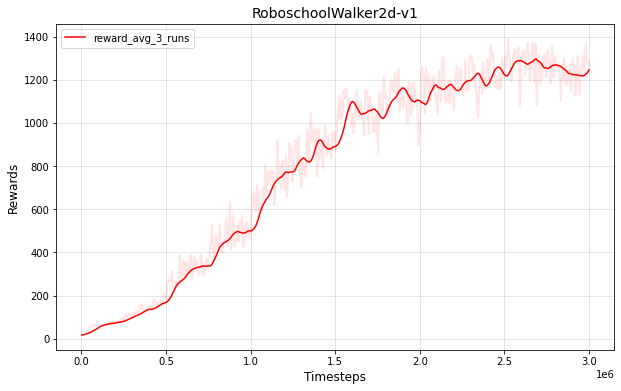

In [ ]:

import os
import pandas as pd
import matplotlib.pyplot as plt


print("============================================================================================")

env_name = 'pong'
# env_name = 'LunarLander-v2'
# env_name = 'BipedalWalker-v2'
# env_name = 'RoboschoolWalker2d-v1'


fig_num = 0     #### change this to prevent overwriting figures in same env_name folder

plot_avg = True    # plot average of all runs; else plot all runs separately

fig_width = 10
fig_height = 6


# smooth out rewards to get a smooth and a less smooth (var) plot lines
window_len_smooth = 50
min_window_len_smooth = 1
linewidth_smooth = 1.5
alpha_smooth = 1

window_len_var = 5
min_window_len_var = 1
linewidth_var = 2
alpha_var = 0.1


colors = ['red', 'blue', 'green', 'orange', 'purple', 'olive', 'brown', 'magenta', 'cyan', 'crimson','gray', 'black']


# make directory for saving figures
figures_dir = "PPO_figs"
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)

# make environment directory for saving figures
figures_dir = figures_dir + '/' + env_name + '/'
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)


fig_save_path = figures_dir + '/PPO_' + env_name + '_fig_' + str(fig_num) + '.png'


# get number of log files in directory
log_dir = "PPO_logs" + '/' + env_name + '/'

current_num_files = next(os.walk(log_dir))[2]
num_runs = len(current_num_files)


all_runs = []

for run_num in range(num_runs):

    log_f_name = log_dir + '/PPO_' + env_name + "_log_" + str(run_num) + ".csv"
    print("loading data from : " + log_f_name)
    data = pd.read_csv(log_f_name)
    data = pd.DataFrame(data)
    
    print("data shape : ", data.shape)
    
    all_runs.append(data)
    print("--------------------------------------------------------------------------------------------")


ax = plt.gca()

if plot_avg:
    # average all runs
    df_concat = pd.concat(all_runs)
    df_concat_groupby = df_concat.groupby(df_concat.index)
    data_avg = df_concat_groupby.mean()

    # smooth out rewards to get a smooth and a less smooth (var) plot lines
    data_avg['reward_smooth'] = data_avg['reward'].rolling(window=window_len_smooth, win_type='triang', min_periods=min_window_len_smooth).mean()
    data_avg['reward_var'] = data_avg['reward'].rolling(window=window_len_var, win_type='triang', min_periods=min_window_len_var).mean()

    data_avg.plot(kind='line', x='timestep' , y='reward_smooth',ax=ax,color=colors[0],  linewidth=linewidth_smooth, alpha=alpha_smooth)
    data_avg.plot(kind='line', x='timestep' , y='reward_var',ax=ax,color=colors[0],  linewidth=linewidth_var, alpha=alpha_var)

    # keep only reward_smooth in the legend and rename it
    handles, labels = ax.get_legend_handles_labels()
    ax.legend([handles[0]], ["reward_avg_" + str(len(all_runs)) + "_runs"], loc=2)


else:
    for i, run in enumerate(all_runs):
        # smooth out rewards to get a smooth and a less smooth (var) plot lines
        run['reward_smooth_' + str(i)] = run['reward'].rolling(window=window_len_smooth, win_type='triang', min_periods=min_window_len_smooth).mean()
        run['reward_var_' + str(i)] = run['reward'].rolling(window=window_len_var, win_type='triang', min_periods=min_window_len_var).mean()
        
        # plot the lines
        run.plot(kind='line', x='timestep' , y='reward_smooth_' + str(i),ax=ax,color=colors[i % len(colors)],  linewidth=linewidth_smooth, alpha=alpha_smooth)
        run.plot(kind='line', x='timestep' , y='reward_var_' + str(i),ax=ax,color=colors[i % len(colors)],  linewidth=linewidth_var, alpha=alpha_var)

    # keep alternate elements (reward_smooth_i) in the legend
    handles, labels = ax.get_legend_handles_labels()
    new_handles = []
    new_labels = []
    for i in range(len(handles)):
        if(i%2 == 0):
            new_handles.append(handles[i])
            new_labels.append(labels[i])
    ax.legend(new_handles, new_labels, loc=2)



# ax.set_yticks(np.arange(0, 1800, 200))
# ax.set_xticks(np.arange(0, int(4e6), int(5e5)))


ax.grid(color='gray', linestyle='-', linewidth=1, alpha=0.2)

ax.set_xlabel("Timesteps", fontsize=12)
ax.set_ylabel("Rewards", fontsize=12)

plt.title(env_name, fontsize=14)


fig = plt.gcf()
fig.set_size_inches(fig_width, fig_height)

print("============================================================================================")

plt.savefig(fig_save_path)
print("figure saved at : ", fig_save_path)

print("============================================================================================")


plt.show()




In [ ]:



################################ End of Part IV ################################




################################################################################
> # **Part - V**

*   install virtual display libraries for rendering on colab / remote server ^
*   load preTrained networks and save images for gif
*   generate and save gif from previously saved images

*   ^ If running locally; do not install xvbf and pyvirtualdisplay. Just comment out the virtual display code and render it normally. 
*   ^ You will still require to use ipythondisplay, if you want to render it in the Jupyter Notebook.

################################################################################

In [ ]:


#### to render on colab / server / headless machine install virtual display libraries

!apt-get install -y xvfb python-opengl > /dev/null 2>&1

!pip install gym pyvirtualdisplay > /dev/null 2>&1



In [ ]:


############################# save images for gif ##############################


import os
import glob

import gym
import roboschool
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


from IPython import display as ipythondisplay

from pyvirtualdisplay import Display



"""
One frame corresponding to each timestep is saved in a folder :

PPO_gif_images/env_name/000001.jpg
PPO_gif_images/env_name/000002.jpg
PPO_gif_images/env_name/000003.jpg
...
...
...


if this section is run multiple times or for multiple episodes for the same env_name; 
then the saved images will be overwritten.

"""




#### beginning of virtual display code section

display = Display(visible=0, size=(400, 300))
display.start()

#### end of virtual display code section



print("============================================================================================")


################## hyperparameters ##################

env_name = "pong"
has_continuous_action_space = False
max_ep_len = 400
action_std = None


# env_name = "LunarLander-v2"
# has_continuous_action_space = False
# max_ep_len = 300
# action_std = None

# env_name = "BipedalWalker-v2"
# has_continuous_action_space = True
# max_ep_len = 1500           # max timesteps in one episode
# action_std = 0.1            # set same std for action distribution which was used while saving

# env_name = "RoboschoolWalker2d-v1"
# has_continuous_action_space = True
# max_ep_len = 1000           # max timesteps in one episode
# action_std = 0.1            # set same std for action distribution which was used while saving


total_test_episodes = 1     # save gif for only one episode

render_ipython = False      # plot the images using matplotlib and ipythondisplay before saving (slow)

K_epochs = 80               # update policy for K epochs
eps_clip = 0.2              # clip parameter for PPO
gamma = 0.99                # discount factor

lr_actor = 0.0003         # learning rate for actor
lr_critic = 0.001         # learning rate for critic

#####################################################


env = pongGym.DoublePong()

# state space dimension
state_dim = env.observation_space.shape[0]

# action space dimension
if has_continuous_action_space:
    action_dim = env.action_space.shape[0]
else:
    action_dim = env.action_space.n



# make directory for saving gif images
gif_images_dir = "PPO_gif_images" + '/'
if not os.path.exists(gif_images_dir):
    os.makedirs(gif_images_dir)

# make environment directory for saving gif images
gif_images_dir = gif_images_dir + '/' + env_name + '/'
if not os.path.exists(gif_images_dir):
    os.makedirs(gif_images_dir)

# make directory for gif
gif_dir = "PPO_gifs" + '/'
if not os.path.exists(gif_dir):
    os.makedirs(gif_dir)

# make environment directory for gif
gif_dir = gif_dir + '/' + env_name  + '/'
if not os.path.exists(gif_dir):
    os.makedirs(gif_dir)



ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)


# preTrained weights directory

random_seed = 0             #### set this to load a particular checkpoint trained on random seed
run_num_pretrained = 0      #### set this to load a particular checkpoint num


directory = "PPO_preTrained" + '/' + env_name + '/'
checkpoint_path = directory + "PPO_{}_{}_{}.pth".format(env_name, random_seed, run_num_pretrained)
print("loading network from : " + checkpoint_path)

ppo_agent.load(checkpoint_path)

print("--------------------------------------------------------------------------------------------")



test_running_reward = 0

for ep in range(1, total_test_episodes+1):
    
    ep_reward = 0
    state = env.reset()

    for t in range(1, max_ep_len+1):
        action = ppo_agent.select_action(state)
        state, reward, done, _ = env.step(action)
        ep_reward += reward

        img = env.render(mode = 'rgb_array')


        #### beginning of ipythondisplay code section 1

        if render_ipython:
            plt.imshow(img)
            ipythondisplay.clear_output(wait=True)
            ipythondisplay.display(plt.gcf())

        #### end of ipythondisplay code section 1


        img = Image.fromarray(img)
        img.save(gif_images_dir + '/' + str(t).zfill(6) + '.jpg')
        
        if done:
            break
    
    # clear buffer    
    ppo_agent.buffer.clear()
    
    test_running_reward +=  ep_reward
    print('Episode: {} \t\t Reward: {}'.format(ep, round(ep_reward, 2)))
    ep_reward = 0



env.close()


#### beginning of ipythondisplay code section 2

if render_ipython:
    ipythondisplay.clear_output(wait=True)

#### end of ipythondisplay code section 2




print("============================================================================================")

print("total number of frames / timesteps / images saved : ", t)

avg_test_reward = test_running_reward / total_test_episodes
avg_test_reward = round(avg_test_reward, 2)
print("average test reward : " + str(avg_test_reward))

print("============================================================================================")







In [ ]:



######################## generate gif from saved images ########################


print("============================================================================================")

env_name = 'pong'
# env_name = 'LunarLander-v2'
# env_name = 'BipedalWalker-v2'
# env_name = 'RoboschoolWalker2d-v1'


gif_num = 0     #### change this to prevent overwriting gifs in same env_name folder

# adjust following parameters to get desired duration, size (bytes) and smoothness of gif
total_timesteps = 300
step = 10
frame_duration = 150


# input images
gif_images_dir = "PPO_gif_images/" + env_name + '/*.jpg'


# ouput gif path
gif_dir = "PPO_gifs"
if not os.path.exists(gif_dir):
    os.makedirs(gif_dir)

gif_dir = gif_dir + '/' + env_name
if not os.path.exists(gif_dir):
    os.makedirs(gif_dir)

gif_path = gif_dir + '/PPO_' + env_name + '_gif_' + str(gif_num) + '.gif'



img_paths = sorted(glob.glob(gif_images_dir))
img_paths = img_paths[:total_timesteps]
img_paths = img_paths[::step]


print("total frames in gif : ", len(img_paths))
print("total duration of gif : " + str(round(len(img_paths) * frame_duration / 1000, 2)) + " seconds")



# save gif
img, *imgs = [Image.open(f) for f in img_paths]
img.save(fp=gif_path, format='GIF', append_images=imgs, save_all=True, optimize=True, duration=frame_duration, loop=0)

print("saved gif at : ", gif_path)



print("============================================================================================")




In [ ]:

############################# check gif byte size ##############################


import os
import glob


print("============================================================================================")

env_name = 'CartPole-v1'
# env_name = 'LunarLander-v2'
# env_name = 'BipedalWalker-v2'
# env_name = 'RoboschoolWalker2d-v1'


gif_dir = "PPO_gifs/" + env_name + '/*.gif'

gif_paths = sorted(glob.glob(gif_dir))

for gif_path in gif_paths:
    file_size = os.path.getsize(gif_path)
    print(gif_path + '\t\t' + str(round(file_size / (1024 * 1024), 2)) + " MB")


print("============================================================================================")





In [ ]:



################################# End of Part V ################################




################################################################################

---------------------------------------------------------------------------- That's all folks ! ----------------------------------------------------------------------------


################################################################################